In [12]:
import os
import json
import pandas as pd
from cobra.io import read_sbml_model
from cobra.flux_analysis import single_gene_deletion
from collections import defaultdict


In [2]:
microbes_list = pd.read_csv("/home/javad/pyprojects/MO_GEMs_Score/GraphRAG/data/subsystem_scores_per_microbe.csv")

In [3]:
microbes_list.head()

Pathways  \
0                    Transport, extracellular   
1                           Lysine metabolism   
2              Glycerophospholipid metabolism   
3                        Fatty acid synthesis   
4  Valine, leucine, and isoleucine metabolism   

   Ruminococcus_champanellensis_18P13  \
0                        1.032208e+01   
1                        1.401583e-01   
2                        1.057417e+01   
3                        1.006081e-15   
4                        0.000000e+00   

   Bifidobacterium_longum_longum_ATCC_55813  Veillonella_parvula_Te3_DSM_2008  \
0                              3.696395e+01                         15.825589   
1                              1.438989e-01                         39.169100   
2                              6.926791e+00                         14.544699   
3                              9.131037e-18                          0.034666   
4                              5.416836e+01                         31.550394   

   Mycoplasma_hominis_ATCC_23114  Bifidobacterium_longum_longum_CCUG_52486  \
0                   6.357982e-02                              3.577133e+01   
1                   3.826223e-21                              1.377064e-01   
2                   1.179105e+01                              8.337046e+00   
3                   3.329664e-03                              3.330634e-17   
4                   2.724817e-03                              5.232436e+01   

   Bacteroides_xylanisolvens_XB1A  Acidaminococcus_intestini_RyC_MR95  \
0                       23.130707                           30.241773   
1                       39.533871                           89.467853   
2                        3.652043                           15.031776   
3                        0.063624                            0.065502   
4                       41.385394                           49.266963   

   Clostridium_sporogenes_ATCC_15579  \
0                          30.582074   
1                           0.123237   
2                           8.403231   
3                           6.062487   
4                           0.095350   

   Bifidobacterium_longum_infantis_ATCC_15697  ...  \
0                                1.324477e+01  ...   
1                                9.391875e-02  ...   
2                                8.211440e+00  ...   
3                                2.523718e-18  ...   
4                                5.753625e+01  ...   

   Desulfovibrio_piger_ATCC_29098  Faecalibacterium_prausnitzii_L2_6  \
0                       21.976751                          10.897947   
1                      246.828341                           0.119688   
2                       10.778320                          12.144894   
3                        0.032385                           5.064725   
4                       53.123013                          43.929376   

   Bacteroides_cellulosilyticus_DSM_14838  \
0                               60.063672   
1                               48.214516   
2                                4.516368   
3                                0.301306   
4                               43.668153   

   Methanobrevibacter_smithii_ATCC_35061  Anaerostipes_hadrus_DSM_3319  \
0                              14.837152                     15.394125   
1                               0.057459                    159.437902   
2                              17.271701                      8.826568   
3                               6.475962                      6.142270   
4                              56.000392                     33.673923   

   Haemophilus_parainfluenzae_T3T1  Clostridium_bolteae_ATCC_BAA_613  \
0                        18.172340                      2.368765e+01   
1                        77.697953                      4.504619e+01   
2                         8.647526                      1.456048e+01   
3                         0.013349                      1.884192e-15   
4                        

In [20]:
# list(microbes_list['Pathways'])

In [7]:
microbes = list(microbes_list.keys())

AGORA_baseURL = "https://www.vmh.life/files/reconstructions/AGORA/1.03/reconstructions/sbml/"

output_dir = "agora_models"
os.makedirs(output_dir, exist_ok=True)

#Download XML files
for microbe in microbes:
    filename = f"{microbe}.xml"
    url = AGORA_baseURL + filename
    output_path = os.path.join(output_dir, filename)
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {filename}")
    except requests.HTTPError as e:
        print(f"Failed to download {filename}: {e}")


Failed to download Pathways.xml: 404 Client Error: Not Found for url: https://www.vmh.life/files/reconstructions/AGORA/1.03/reconstructions/sbml/Pathways.xml
Downloaded: Ruminococcus_champanellensis_18P13.xml
Downloaded: Bifidobacterium_longum_longum_ATCC_55813.xml
Downloaded: Veillonella_parvula_Te3_DSM_2008.xml
Downloaded: Mycoplasma_hominis_ATCC_23114.xml
Downloaded: Bifidobacterium_longum_longum_CCUG_52486.xml
Downloaded: Bacteroides_xylanisolvens_XB1A.xml
Downloaded: Acidaminococcus_intestini_RyC_MR95.xml
Downloaded: Clostridium_sporogenes_ATCC_15579.xml
Downloaded: Bifidobacterium_longum_infantis_ATCC_15697.xml
Downloaded: Lactobacillus_ruminis_ATCC_25644.xml
Downloaded: Campylobacter_hominis_ATCC_BAA_381.xml
Downloaded: Bacteroides_dorei_DSM_17855.xml
Downloaded: Coprococcus_catus_GD_7.xml
Downloaded: Bifidobacterium_bifidum_PRL2010.xml
Downloaded: Ruminococcus_obeum_A2_162.xml
Downloaded: Bacteroides_vulgatus_ATCC_8482.xml
Downloaded: Bacteroides_ovatus_SD_CMC_3f.xml
Downloaded

## Identify Essential genes

AND save them into  a JSON file

In [10]:
#load rxn subsystem info
with open("/home/javad/pyprojects/MO_GEMs_Score/GraphRAG/data/reaction_info.json", "r") as f:
    reaction_info = json.load(f)

In [21]:
target_subsystems = {
    "NAD metabolism",                      # NAD biosynthesis & salvage
    "CoA synthesis",                      # Coenzyme A biosynthesis
    "Folate metabolism",                  # Folic acid (vitamin B9)
    "Thiamine metabolism",                # Vitamin B1
    "Vitamin B2 metabolism",              # Riboflavin
    "Vitamin B6 metabolism",              # Pyridoxal phosphate
    "Vitamin B12 metabolism",             # Cobalamin
    "Biotin metabolism",                  # Biotin (vitamin B7)
    "Fatty acid synthesis",               # Lipid membrane precursors
    "Cell wall biosynthesis",            # Peptidoglycan biosynthesis
    "Lipopolysaccharide biosynthesis",    # LPS barrier in Gram-negative bacteria
    "Energy metabolism",                 # General redox/ATP balance
    "Oxidative phosphorylation",          # NADH >> ATP production
    "Citric acid cycle",                 # Central to energy generation
    "Glycolysis/gluconeogenesis"         # Basic metabolic flux
    }


In [29]:
def assign_fluxes(model, medium_type: str, diet_data: pd.DataFrame, oxygen_status: str):
      
    if medium_type not in ["fat", "High fiber diet", "rich"]:
        raise ValueError("Invalid medium type. Choose 'High fat diet', 'High fiber diet', or 'rich'.")
    if oxygen_status not in ["present", "absent"]:
        raise ValueError("Invalid oxygen status. Choose 'present' or 'absent'.")

    o2Rxn = "EX_o2(e)"  
    if o2Rxn in model.reactions:
        if oxygen_status == "present":
            model.reactions.get_by_id(o2Rxn).lower_bound = -10
        elif oxygen_status == "absent":
            model.reactions.get_by_id(o2Rxn).lower_bound = 0

    if medium_type == "rich":
        #open all fluxes
        for rxn in model.exchanges:
            # if "EX_" in reaction.id:  #exchange rxns start with "EX_"
            rxn.lower_bound = -1000
            rxn.upper_bound = 1000
    else:
        #reset all exchange rxn lower bounds to 0
        for rxn in model.exchanges:
            # if "EX_" in rxn.id:  
            rxn.lower_bound = 0
        
        #assign fluxes 
        noRxns = 0
        skippedRxns = 0
        for _, row in diet_data.iterrows():
            rxn_id = row["Exchange rxn ID"]
            flux_value = row[medium_type]
            
            #check if the rxn exists in the model
            if rxn_id in model.reactions:
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.lower_bound = -flux_value
                rxn.upper_bound = 1000
                noRxns += 1
            else:
                #log rxns not found
                skippedRxns += 1
                # print(f"Reaction {rxn_id} not found in the model. Skipping.")

    print(f"Total added fluxes: {noRxns}")

In [28]:
diet_data = pd.read_excel("/home/javad/pyprojects/MO_GEMs_Score/graphNN/data/medium_list.xlsx", sheet_name="Table_1")

In [76]:
import os
import json
from collections import defaultdict
from cobra.io import read_sbml_model
from cobra.flux_analysis import single_gene_deletion
from multiprocessing import cpu_count
from tqdm import tqdm

In [77]:
model_dir = "agora_models"
reaction_info_path = "reaction_info.json"
output_json = "essential_drug_target_genes.json"
diet_type = "High fiber diet"
o2_status = "absent"

relevant_rxns = {rxn_id for rxn_id, info in reaction_info.items()
            if info.get("Subsystem") in target_subsystems}

results = {}
readable_lines = []
# --- Process each model ---
i=0
for filename in os.listdir(model_dir):
    # i+=1
    # if i==4:
    #     break
    if not filename.endswith(".xml"):
        continue

    model_name = filename.replace(".xml", "")
    model_path = os.path.join(model_dir, filename)
    print(f"Processing: {model_name}")

    try:
        model = read_sbml_model(model_path)
        assign_fluxes(model, diet_type, diet_data, o2_status)
        

        gene_to_reactions = defaultdict(list)
        for rxn_id in relevant_rxns:
            if rxn_id in model.reactions:
                rxn = model.reactions.get_by_id(rxn_id)
                
                for gene in rxn.genes:
                    gene_to_reactions[gene.id].append({
                        "reaction": rxn.id,
                        "subsystem": reaction_info.get(rxn.id, {}).get("Subsystem", "Unknown")
                    })
        # print('ppp')
        # print(gene_to_reactions)
        if not gene_to_reactions:
            print("  No relevant genes found.")
            continue

        # wild-type growth
        wild_type_growth = model.slim_optimize()
        if wild_type_growth is None or wild_type_growth < 1e-6:
            print("  No growth in wild-type. Skipping.")
            continue
        threshold = 0.05 * wild_type_growth

        # gene knockouts only for relevant genes
        gene_list = list(gene_to_reactions.keys())

        gene_id_list = list(gene_to_reactions.keys())
        # print(gene_id_list)
        gene_objects = [model.genes.get_by_id(g) for g in gene_id_list]
        gene_index_to_id = {i: gene.id for i, gene in enumerate(gene_objects)}
        
        # Run deletion
        deletion_results = single_gene_deletion(model, gene_list=gene_objects)
        
        essential_gene_indices = deletion_results[deletion_results["growth"] < threshold].index.tolist()
        # print(essential_gene_indices)
        #Convert back to real gene IDs
        essential_genes = [gene_index_to_id[i] for i in essential_gene_indices]
        # print('xxx')
        # print(essential_genes)

        model_essentials = []
        readable_lines.append(f"{model_name}")
        for gene in essential_genes:
            reactions = gene_to_reactions[gene]
            model_essentials.append({"gene": gene, "reactions": reactions})

            rxn_str = ", ".join(f"{r['reaction']} ({r['subsystem']})" for r in reactions)
            readable_lines.append(f"  {gene} >> {rxn_str}")

        if model_essentials:
            results[model_name] = model_essentials
        print(f"  {len(model_essentials)} essential genes found.")

    except Exception as e:
        print(f"  Error in {model_name}: {e}")

Processing: Streptococcus_pneumoniae_G54
Total added fluxes: 91
  31 essential genes found.
Processing: Bifidobacterium_longum_E18
Total added fluxes: 73


Process ForkPoolWorker-5135:
Process ForkPoolWorker-5134:
Exception ignored in: <function _releaseLock at 0x7e3c6c19c1f0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-5132:
Process ForkPoolWorker-5133:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/pyth

KeyboardInterrupt: 

Process ForkPoolWorker-5142:
Process ForkPoolWorker-5140:
Process ForkPoolWorker-5144:
Process ForkPoolWorker-5143:
Process ForkPoolWorker-5146:
Process ForkPoolWorker-5145:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.ru

In [70]:
with open(output_json, "w") as f:
    json.dump(results, f, indent=2)


print(f"\n✅ Saved structured JSON to: {output_json}")



✅ Saved structured JSON to: essential_drug_target_genes.json


## Read json file including list of essential genes for every microbe under high fiber diet

Get corresponding KO for each essential gene from VMH

Retrieve GenBank files for each microbe

Use KO functionalities to find protein seqs for essential genes



In [119]:
import os
import json
import requests
import time
import gzip
import pandas as pd
import time
from tqdm import tqdm
from Bio import Entrez, SeqIO

Entrez.email = "javadamn@gmail.com"

In [112]:
with open("essential_drug_target_genes.json") as f:
    microbes_ess_genes = json.load(f)

In [115]:
unique_genes = set()
for gene_list in microbes_ess_genes.values():
    for entry in gene_list:
        unique_genes.add(entry["gene"])

In [116]:
len(unique_genes)

2463

In [148]:
def fetch_gene_annotations(gene_id):
    url = f"https://www.vmh.life/_api/microbegenereactions/{gene_id}/"
    # print(url)
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error fetching gene {gene_id}: {e}")
        return None

In [154]:
all_gene_annotations = {}
seen_genes = set()
records = []

unique_genes = {}
for model, gene_entries in microbes_ess_genes.items():
    for entry in gene_entries:
        gene_id = entry["gene"]
        if gene_id not in seen_genes:
            seen_genes.add(gene_id)
            unique_genes[gene_id] = model  
print(f"Number of unique gene IDs: {len(unique_genes)}")

# i = 0
for gene_id in tqdm(unique_genes, desc="Fetching gene annotations"):
    # i += 1
    # if i > 5:
    #     break
    annotation = fetch_gene_annotations(gene_id)
    if annotation:
        all_gene_annotations[gene_id] = annotation
        results = annotation.get("results", [])
        
        for item in results:
            kegg_orthology = item.get("keggorthology", None)
            if kegg_orthology:
                kegg_orthology = kegg_orthology.strip().split()  #split into multiple KEGG orthologies if needed
            ecnumber = item.get("ecnumber", None)
            subsystem = item.get("subsystem", None)
            description = item.get("description", None)
            isHuman = item.get("isHuman", None)
            seed = item.get("seed", None)
            
            #None if not available
            if kegg_orthology:
                for ko in kegg_orthology:
                    records.append({
                        "model": unique_genes[gene_id],
                        "gene_id": gene_id,
                        "kegg_orthology": ko,
                        "ecnumber": ecnumber,
                        "subsystem": subsystem,
                        "description": description,
                        "isHuman": isHuman,
                        "seedID": seed
                                        })
            else:
                records.append({
                            "model": unique_genes[gene_id],
                            "gene_id": gene_id,
                            "kegg_orthology": None,
                            "ecnumber": ecnumber,
                            "subsystem": subsystem,
                            "description": description,
                            "isHuman": isHuman,
                            "seedID": seed
                                                        })
    else:
        records.append({
                        "model": unique_genes[gene_id],
                        "gene_id": gene_id,
                        "kegg_orthology": None,
                        "ecnumber": None,
                        "subsystem": None,
                        "description": None,
                        "isHuman": None,
                        "seedID": None
                                                                })
    time.sleep(0.3)

gene_df = pd.DataFrame(records)


Number of unique gene IDs: 2463


Fetching gene annotations: 100%|████████████| 2463/2463 [50:33<00:00,  1.23s/it]


In [159]:
# gene_df['gene_id']== '709991.5.peg.2285'

In [161]:
strain_accession_mapping = pd.read_csv("xml_w_genome_accession.csv")

In [162]:
merged_df = gene_df.merge(strain_accession_mapping[['strain_name', 'genome_accession']], 
                          how='left', 
                          left_on='model', 
                          right_on='strain_name')

merged_df.drop(columns=['strain_name'], inplace=True)
# merged_df.head()

model          gene_id kegg_orthology  ecnumber  \
0  Streptococcus_pneumoniae_G54  g.1878.peg.1024           None      None   
1  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00605  2.1.2.10   
2  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00281  2.1.2.10   
3  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00282  2.1.2.10   
4  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00283  2.1.2.10   

                                           subsystem  \
0                                  Folate metabolism   
1  Glycine, serine, alanine and threonine metabolism   
2                                  Folate metabolism   
3                                  Folate metabolism   
4                                  Folate metabolism   

                description  isHuman    seedID genome_accession  
0    Aminomethyltransferase    False  rxn01652  GCF_000019825.1  
1  Glycine cleavage complex    False  rxn06600  GCF_000019825.1  
2   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  
3   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  
4   Glycine Cleavage System    False  rxn00908  GCF_000019825.1

In [196]:
merged_df = gene_df.merge(strain_accession_mapping[['strain_name', 'ncbiid']], 
                          how='left', 
                          left_on='model', 
                          right_on='strain_name')

merged_df.drop(columns=['strain_name'], inplace=True)
# merged_df.head()

model          gene_id kegg_orthology  ecnumber  \
0  Streptococcus_pneumoniae_G54  g.1878.peg.1024           None      None   
1  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00605  2.1.2.10   
2  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00281  2.1.2.10   
3  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00282  2.1.2.10   
4  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00283  2.1.2.10   

                                           subsystem  \
0                                  Folate metabolism   
1  Glycine, serine, alanine and threonine metabolism   
2                                  Folate metabolism   
3                                  Folate metabolism   
4                                  Folate metabolism   

                description  isHuman    seedID genome_accession  ncbiid  
0    Aminomethyltransferase    False  rxn01652  GCF_000019825.1  512566  
1  Glycine cleavage complex    False  rxn06600  GCF_000019825.1  512566  
2   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566  
3   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566  
4   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566

In [217]:
gene_df = merged_df

In [218]:
gene_df.to_csv('gene_df_info.csv', index=False)

print(f"Saved structured dataFrame")

Saved structured dataFrame


## Download GenBank files with genome accession ids

In [256]:
import pandas as pd
from Bio import Entrez, SeqIO
import os
import requests
import gzip
import shutil

Entrez.email = "javadamn@gmail.com"
output_dir = "/GenBank_files"
# os.makedirs(output_dir, exist_ok=True)

In [231]:
gene_df = pd.read_csv("gene_df_info.csv")

In [237]:
gene_df = gene_df.drop_duplicates(subset="genome_accession")


In [167]:
accessions = gene_df['genome_accession'].dropna().unique()

In [254]:
accessions = [
    ("GCF_000019825.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/019/825/GCF_000019825.1_ASM1982v1/GCF_000019825.1_ASM1982v1_genomic.gbff.gz"),
    ("GCF_000497735.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/497/735/GCF_000497735.1_BLONGv1.0/GCF_000497735.1_BLONGv1.0_genomic.gbff.gz"),
    ("GCF_000024945.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/024/945/GCF_000024945.1_ASM2494v1/GCF_000024945.1_ASM2494v1_genomic.gbff.gz"),
    ("GCA_949495995.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/949/495/995/GCA_949495995.1_extra-SRR8581395.6_1677803352/GCA_949495995.1_extra-SRR8581395.6_1677803352_genomic.gbff.gz"),
    ("GCF_003010495.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/003/010/495/GCF_003010495.1_ASM301049v1/GCF_003010495.1_ASM301049v1_genomic.gbff.gz"),
    ("GCF_000007525.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/007/525/GCF_000007525.1_ASM752v1/GCF_000007525.1_ASM752v1_genomic.gbff.gz"),
    ("GCF_000157015.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/157/015/GCF_000157015.1_ASM15701v1/GCF_000157015.1_ASM15701v1_genomic.gbff.gz"),
    ("GCA_042848235.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/042/848/235/GCA_042848235.1_ASM4284823v1/GCA_042848235.1_ASM4284823v1_genomic.gbff.gz"),
    ("GCF_020736405.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/020/736/405/GCF_020736405.1_ASM2073640v1/GCF_020736405.1_ASM2073640v1_genomic.gbff.gz"),
    ("GCF_000025925.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/025/925/GCF_000025925.1_ASM2592v1/GCF_000025925.1_ASM2592v1_genomic.gbff.gz"),
    ("GCF_000225345.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/225/345/GCF_000225345.1_ASM22534v1/GCF_000225345.1_ASM22534v1_genomic.gbff.gz"),
    ("GCF_020735645.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/020/735/645/GCF_020735645.1_ASM2073564v1/GCF_020735645.1_ASM2073564v1_genomic.gbff.gz"),
    ("GCF_000092325.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/092/325/GCF_000092325.1_ASM9232v1/GCF_000092325.1_ASM9232v1_genomic.gbff.gz"),
    ("GCF_048164435.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/048/164/435/GCF_048164435.1_ASM4816443v1/GCF_048164435.1_ASM4816443v1_genomic.gbff.gz"),
    ("GCF_000239295.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/239/295/GCF_000239295.1_ASM23929v1/GCF_000239295.1_ASM23929v1_genomic.gbff.gz"),
    ("GCF_000017585.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/017/585/GCF_000017585.1_ASM1758v1/GCF_000017585.1_ASM1758v1_genomic.gbff.gz"),
    ("GCF_000210095.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/095/GCF_000210095.1_ASM21009v1/GCF_000210095.1_ASM21009v1_genomic.gbff.gz"),
    ("GCF_000155415.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/155/415/GCF_000155415.1_ASM15541v1/GCF_000155415.1_ASM15541v1_genomic.gbff.gz"),
    ("GCF_964246395.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/246/395/GCF_964246395.1_ASM96424639v1/GCF_964246395.1_ASM96424639v1_genomic.gbff.gz"),
    ("GCF_030296915.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/030/296/915/GCF_030296915.1_ASM3029691v1/GCF_030296915.1_ASM3029691v1_genomic.gbff.gz"),
    ("GCF_000230275.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/230/275/GCF_000230275.1_ASM23027v1/GCF_000230275.1_ASM23027v1_genomic.gbff.gz"),
    ("GCF_000173975.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/173/975/GCF_000173975.1_ASM17397v1/GCF_000173975.1_ASM17397v1_genomic.gbff.gz"),
    ("GCF_000024265.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/024/265/GCF_000024265.1_ASM2426v1/GCF_000024265.1_ASM2426v1_genomic.gbff.gz"),
    ("GCF_000155085.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/155/085/GCF_000155085.1_ASM15508v1/GCF_000155085.1_ASM15508v1_genomic.gbff.gz"),
    ("GCF_900624795.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/624/795/GCF_900624795.1_ASM90062479v1/GCF_900624795.1_ASM90062479v1_genomic.gbff.gz"),
    ("GCA_964240745.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/964/240/745/GCA_964240745.1_ASM96424074v1/GCA_964240745.1_ASM96424074v1_genomic.gbff.gz"),
    ("GCF_000166315.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/166/315/GCF_000166315.1_ASM16631v1/GCF_000166315.1_ASM16631v1_genomic.gbff.gz"),
    ("GCF_000210015.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/015/GCF_000210015.1_ASM21001v1/GCF_000210015.1_ASM21001v1_genomic.gbff.gz"),
    ("GCF_000478885.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/478/885/GCF_000478885.1_ASM47888v1/GCF_000478885.1_ASM47888v1_genomic.gbff.gz"),
    ("GCF_000209975.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/209/975/GCF_000209975.1_ASM20997v1/GCF_000209975.1_ASM20997v1_genomic.gbff.gz"),
    ("GCF_000156075.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/156/075/GCF_000156075.1_ASM15607v1/GCF_000156075.1_ASM15607v1_genomic.gbff.gz"),
    ("GCF_000156375.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/156/375/GCF_000156375.1_ASM15637v1/GCF_000156375.1_ASM15637v1_genomic.gbff.gz"),
    ("GCF_000166895.2", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/166/895/GCF_000166895.2_ASM16689v2/GCF_000166895.2_ASM16689v2_genomic.gbff.gz"),
    ("GCF_000210555.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/555/GCF_000210555.1_ASM21055v1/GCF_000210555.1_ASM21055v1_genomic.gbff.gz"),
    ("GCF_000154385.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/154/385/GCF_000154385.1_ASM15438v1/GCF_000154385.1_ASM15438v1_genomic.gbff.gz"),
    ("GCF_000210895.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/895/GCF_000210895.1_ASM21089v1/GCF_000210895.1_ASM21089v1_genomic.gbff.gz"),
    ("GCF_964260205.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/260/205/GCF_964260205.1_ASM96426020v1/GCF_964260205.1_ASM96426020v1_genomic.gbff.gz"),
    ("GCA_022305115.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/022/305/115/GCA_022305115.1_ASM2230511v1/GCA_022305115.1_ASM2230511v1_genomic.gbff.gz"),
    ("GCF_000164965.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/164/965/GCF_000164965.1_ASM16496v1/GCF_000164965.1_ASM16496v1_genomic.gbff.gz"),
    ("GCF_000183685.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/183/685/GCF_000183685.1_ASM18368v1/GCF_000183685.1_ASM18368v1_genomic.gbff.gz"),
    ("GCF_000209855.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/209/855/GCF_000209855.1_ASM20985v1/GCF_000209855.1_ASM20985v1_genomic.gbff.gz"),
    ("GCF_000178275.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/178/275/GCF_000178275.1_ASM17827v1/GCF_000178275.1_ASM17827v1_genomic.gbff.gz"),
    ("GCF_964259715.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/259/715/GCF_964259715.1_ASM96425971v1/GCF_964259715.1_ASM96425971v1_genomic.gbff.gz"),
    ("GCF_025145845.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/025/145/845/GCF_025145845.1_ASM2514584v1/GCF_025145845.1_ASM2514584v1_genomic.gbff.gz"),
    ("GCF_000169015.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/169/015/GCF_000169015.1_ASM16901v1/GCF_000169015.1_ASM16901v1_genomic.gbff.gz"),
    ("GCF_000165905.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/165/905/GCF_000165905.1_ASM16590v1/GCF_000165905.1_ASM16590v1_genomic.gbff.gz"),
    ("GCF_025147765.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/025/147/765/GCF_025147765.1_ASM2514776v1/GCF_025147765.1_ASM2514776v1_genomic.gbff.gz"),
    ("GCF_000265095.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/265/095/GCF_000265095.1_ASM26509v1/GCF_000265095.1_ASM26509v1_genomic.gbff.gz"),
    ("GCF_040095415.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/040/095/415/GCF_040095415.1_ASM4009541v1/GCF_040095415.1_ASM4009541v1_genomic.gbff.gz"),
    ("GCF_000006865.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/865/GCF_000006865.1_ASM686v1/GCF_000006865.1_ASM686v1_genomic.gbff.gz"),
    ("GCF_000273525.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/273/525/GCF_000273525.1_ASM27352v1/GCF_000273525.1_ASM27352v1_genomic.gbff.gz"),
    ("GCF_000146185.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/185/GCF_000146185.1_ASM14618v1/GCF_000146185.1_ASM14618v1_genomic.gbff.gz"),
    ("GCF_000153925.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/153/925/GCF_000153925.1_ASM15392v1/GCF_000153925.1_ASM15392v1_genomic.gbff.gz"),
    ("GCF_964250545.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/250/545/GCF_964250545.1_ASM96425054v1/GCF_964250545.1_ASM96425054v1_genomic.gbff.gz"),
    ("GCF_964260535.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/260/535/GCF_964260535.1_ASM96426053v1/GCF_964260535.1_ASM96426053v1_genomic.gbff.gz"),
    ("GCF_900445515.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/445/515/GCF_900445515.1_ASM90044551v1/GCF_900445515.1_ASM90044551v1_genomic.gbff.gz"),
    ("GCF_017504145.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/017/504/145/GCF_017504145.1_ASM1750414v1/GCF_017504145.1_ASM1750414v1_genomic.gbff.gz"),
    ("GCF_000003135.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/003/135/GCF_000003135.1_ASM313v1/GCF_000003135.1_ASM313v1_genomic.gbff.gz"),
    ("GCF_000154365.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/154/365/GCF_000154365.1_ASM15436v1/GCF_000154365.1_ASM15436v1_genomic.gbff.gz"),
    ("GCF_000210075.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/075/GCF_000210075.1_ASM21007v1/GCF_000210075.1_ASM21007v1_genomic.gbff.gz"),
    ("GCF_000154125.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/154/125/GCF_000154125.1_ASM15412v1/GCF_000154125.1_ASM15412v1_genomic.gbff.gz"),
    ("GCF_964238615.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/238/615/GCF_964238615.1_ASM96423861v1/GCF_964238615.1_ASM96423861v1_genomic.gbff.gz"),
    ("GCF_900624785.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/624/785/GCF_900624785.1_ASM90062478v1/GCF_900624785.1_ASM90062478v1_genomic.gbff.gz"),
    ("GCF_000196575.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/196/575/GCF_000196575.1_ASM19657v1/GCF_000196575.1_ASM19657v1_genomic.gbff.gz"),
    ("GCF_964239605.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/239/605/GCF_964239605.1_ASM96423960v1/GCF_964239605.1_ASM96423960v1_genomic.gbff.gz"),
    ("GCF_046199715.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/046/199/715/GCF_046199715.1_ASM4619971v1/GCF_046199715.1_ASM4619971v1_genomic.gbff.gz"),
    ("GCF_028743435.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/028/743/435/GCF_028743435.1_ASM2874343v1/GCF_028743435.1_ASM2874343v1_genomic.gbff.gz"),
    ("GCF_964259635.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/259/635/GCF_964259635.1_ASM96425963v1/GCF_964259635.1_ASM96425963v1_genomic.gbff.gz"),
    ("GCF_900537995.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900/537/995/GCF_900537995.1_ASM90053799v1/GCF_900537995.1_ASM90053799v1_genomic.gbff.gz"),
    ("GCF_000210735.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/735/GCF_000210735.1_ASM21073v1/GCF_000210735.1_ASM21073v1_genomic.gbff.gz"),
    ("GCF_000210615.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/615/GCF_000210615.1_ASM21061v1/GCF_000210615.1_ASM21061v1_genomic.gbff.gz"),
    ("GCF_000210035.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/210/035/GCF_000210035.1_ASM21003v1/GCF_000210035.1_ASM21003v1_genomic.gbff.gz"),
    ("GCF_000011825.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/011/825/GCF_000011825.1_ASM1182v1/GCF_000011825.1_ASM1182v1_genomic.gbff.gz"),
    ("GCF_000225845.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/225/845/GCF_000225845.1_ASM22584v1/GCF_000225845.1_ASM22584v1_genomic.gbff.gz"),
    ("GCF_964260485.1", "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/964/260/485/GCF_964260485.1_ASM96426048v1/GCF_964260485.1_ASM96426048v1_genomic.gbff.gz"),
]


In [260]:
len(accessions)

75

In [267]:
output_dir = "/home/javad/pyprojects/MO_GEMs_Score/GraphRAG/geneKnockout/GenBank_files"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


for accession, url in accessions:
    filename = os.path.join(output_dir, f"{accession}.gbff")
    if os.path.exists(filename):
        print(f"Skipping {accession} — file already exists.")
        continue
    
    gz_filename = filename + ".gz"
    print(f"Downloading {accession} to {gz_filename}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() 
        
        with open(gz_filename, 'wb') as f_out:
            shutil.copyfileobj(response.raw, f_out)
        
        with gzip.open(gz_filename, 'rb') as f_in, open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        
        os.remove(gz_filename)
        
        print(f"Downloaded and extracted: {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {accession} from {url}: {e}")

Skipping GCF_000019825.1 — file already exists.
Skipping GCF_000497735.1 — file already exists.
Skipping GCF_000024945.1 — file already exists.
Skipping GCA_949495995.1 — file already exists.
Skipping GCF_003010495.1 — file already exists.
Skipping GCF_000007525.1 — file already exists.
Skipping GCF_000157015.1 — file already exists.
Skipping GCA_042848235.1 — file already exists.
Skipping GCF_020736405.1 — file already exists.
Skipping GCF_000025925.1 — file already exists.
Skipping GCF_000225345.1 — file already exists.
Skipping GCF_020735645.1 — file already exists.
Skipping GCF_000092325.1 — file already exists.
Skipping GCF_048164435.1 — file already exists.
Skipping GCF_000239295.1 — file already exists.
Skipping GCF_000017585.1 — file already exists.
Skipping GCF_000210095.1 — file already exists.
Skipping GCF_000155415.1 — file already exists.
Skipping GCF_964246395.1 — file already exists.
Skipping GCF_030296915.1 — file already exists.
Skipping GCF_000230275.1 — file already 

## Retrieve info for KOs--including functionalities

In [275]:
gene_df = pd.read_csv("gene_df_info.csv")

In [276]:
unique_kos = gene_df['kegg_orthology'].dropna().unique()

In [277]:
#retrieve KO descriptions
kegg_descriptions = {}
for ko in tqdm(unique_kos, desc="Fetching KO definitions"):
    if not ko.startswith("K"):
        continue 
    try:
        response = requests.get(f"https://rest.kegg.jp/get/ko:{ko}", timeout=10)
        # print(ko)
        if response.status_code == 200:
            lines = response.text.split("\n")
            # print(lines)
            for line in lines:
                if line.startswith("NAME"):
                    kegg_descriptions[ko] = line.replace("NAME", "").strip()
                    # print(kegg_descriptions[ko])
                    break
        else:
            kegg_descriptions[ko] = None
    except Exception as e:
        print(f"Failed to fetch KO {ko}: {e}")
        kegg_descriptions[ko] = None

#Mapping....
gene_df['ko_description'] = gene_df['kegg_orthology'].map(kegg_descriptions)


Fetching KO definitions: 100%|████████████████| 483/483 [11:46<00:00,  1.46s/it]


In [280]:
gene_df.to_csv('gene_df_info.csv', index=False)

In [286]:
gene_df.head()

model          gene_id kegg_orthology  ecnumber  \
0  Streptococcus_pneumoniae_G54  g.1878.peg.1024            NaN       NaN   
1  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00605  2.1.2.10   
2  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00281  2.1.2.10   
3  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00282  2.1.2.10   
4  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00283  2.1.2.10   

                                           subsystem  \
0                                  Folate metabolism   
1  Glycine, serine, alanine and threonine metabolism   
2                                  Folate metabolism   
3                                  Folate metabolism   
4                                  Folate metabolism   

                description  isHuman    seedID genome_accession  ncbiid  \
0    Aminomethyltransferase    False  rxn01652  GCF_000019825.1  512566   
1  Glycine cleavage complex    False  rxn06600  GCF_000019825.1  512566   
2   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   
3   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   
4   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   

                                      ko_description matched_gene locus_tag  \
0                                                NaN         None      None   
1  glycine cleavage system T protein (aminomethyl...         None      None   
2  glycine cleavage system P protein (glycine deh...         None      None   
3  glycine cleavage system P protein (glycine deh...         None      None   
4  glycine cleavage system P protein (glycine deh...         None      None   

  protein_id matched_product  
0       None            None  
1       None            None  
2       None            None  
3       None            None  
4       None            None

## Search genes and protein seqs by KO description in GenBank files

In [ ]:
gene_df = pd.read_csv("gene_df_info.csv")

In [285]:
gene_df[['matched_gene', 'locus_tag', 'protein_id', 'matched_product']] = None

gbff_dir = Path("GenBank_files")

In [283]:
for idx, row in tqdm(gene_df.iterrows(), total=gene_df.shape[0], desc="Matching KO to GenBank"):
    accession = row['genome_accession']
    target_function = str(row['ko_description']).strip().lower()
    if not target_function or pd.isna(accession):
        continue  

    gbff_path = gbff_dir / f"{accession}.gbff"
    if not gbff_path.exists():
        print(f"Missing GenBank file: {gbff_path}")
        continue

    #::>> parsing GenBank file 
    found = False
    for record in SeqIO.parse(str(gbff_path), "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                product = feature.qualifiers.get("product", [""])[0].lower()
                if target_function in product:
                    gene = feature.qualifiers.get("gene", ["-"])[0]
                    locus = feature.qualifiers.get("locus_tag", ["-"])[0]
                    protein_id = feature.qualifiers.get("protein_id", ["-"])[0]

                    # Updating
                    gene_df.at[idx, 'matched_gene'] = gene
                    gene_df.at[idx, 'locus_tag'] = locus
                    gene_df.at[idx, 'protein_id'] = protein_id
                    gene_df.at[idx, 'matched_product'] = product
                    found = True
                    break
        if found:
            break



Matching KO to GenBank:   0%|                | 63/12832 [00:17<59:08,  3.60it/s]


KeyboardInterrupt: 

## Essential genes analysis >> grahps

In [ ]:
gene_df = pd.read_csv("gene_df_info.csv")

In [288]:
gene_df.head()

model          gene_id kegg_orthology  ecnumber  \
0  Streptococcus_pneumoniae_G54  g.1878.peg.1024            NaN       NaN   
1  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00605  2.1.2.10   
2  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00281  2.1.2.10   
3  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00282  2.1.2.10   
4  Streptococcus_pneumoniae_G54  g.1878.peg.1024         K00283  2.1.2.10   

                                           subsystem  \
0                                  Folate metabolism   
1  Glycine, serine, alanine and threonine metabolism   
2                                  Folate metabolism   
3                                  Folate metabolism   
4                                  Folate metabolism   

                description  isHuman    seedID genome_accession  ncbiid  \
0    Aminomethyltransferase    False  rxn01652  GCF_000019825.1  512566   
1  Glycine cleavage complex    False  rxn06600  GCF_000019825.1  512566   
2   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   
3   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   
4   Glycine Cleavage System    False  rxn00908  GCF_000019825.1  512566   

                                      ko_description matched_gene locus_tag  \
0                                                NaN         None      None   
1  glycine cleavage system T protein (aminomethyl...         None      None   
2  glycine cleavage system P protein (glycine deh...         None      None   
3  glycine cleavage system P protein (glycine deh...         None      None   
4  glycine cleavage system P protein (glycine deh...         None      None   

  protein_id matched_product  
0       None            None  
1       None            None  
2       None            None  
3       None            None  
4       None            None

In [293]:
gene_df['kegg_orthology'].unique().shape

(484,)

In [347]:
df=gene_df

/tmp/ipykernel_609256/1411573283.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=subsystem_counts.index, x=subsystem_counts.values, palette="viridis")


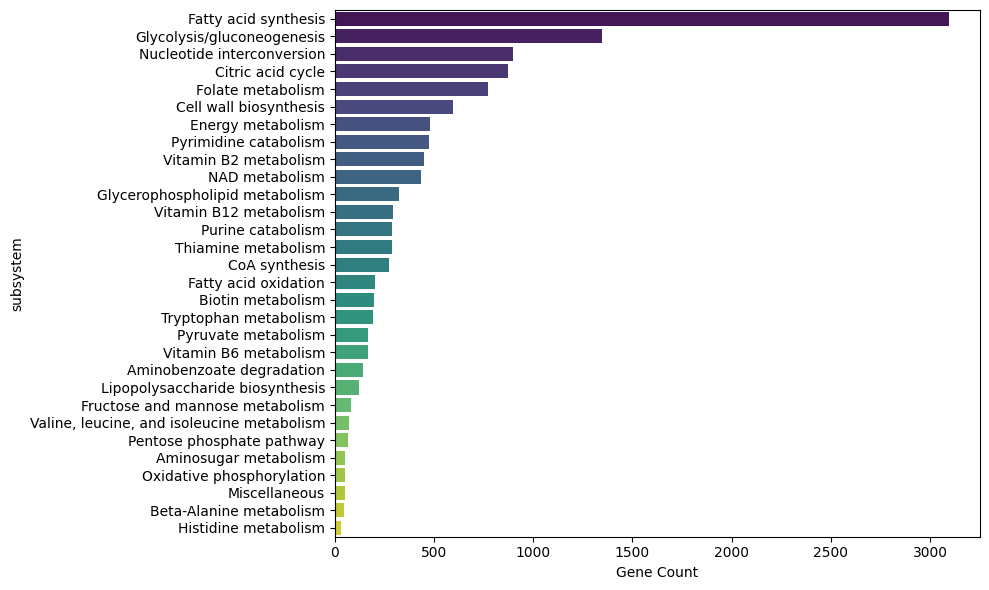

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
subsystem_counts = df['subsystem'].value_counts().head(30)  # Top 20
sns.barplot(y=subsystem_counts.index, x=subsystem_counts.values, palette="viridis")
# plt.title("Top 20 Subsystems by Gene Count")
plt.xlabel("Gene Count")
# plt.ylabel("Subsystem")
plt.tight_layout()
plt.show()


In [348]:
kegg_counts = df['kegg_orthology'].notna().value_counts()
kegg_counts.index = ['With KO', 'Without KO']
kegg_counts.plot(kind='pie', autopct='%1.1f%%', colors=['#4caf50', '#f44336'])
plt.title("Genes with KEGG Orthology Annotations")
plt.ylabel("")
plt.show()


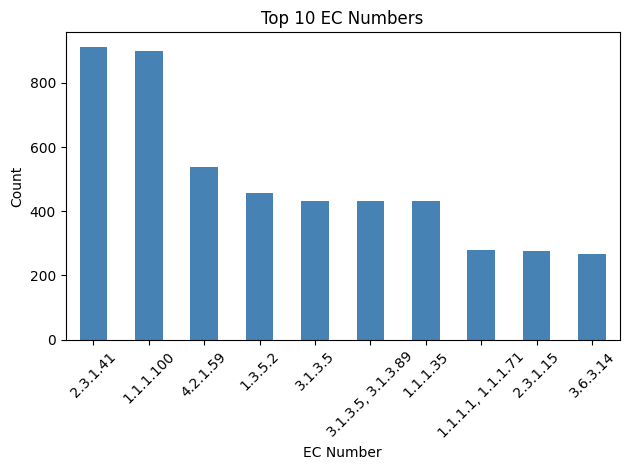

In [297]:
top_ec = df['ecnumber'].value_counts().head(10)
top_ec.plot(kind='bar', color='steelblue')
plt.title("Top 10 EC Numbers")
plt.xlabel("EC Number")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [351]:
model_gene_counts = df.groupby('model')['gene_id'].nunique().sort_values(ascending=False).head(30)
model_gene_counts.plot(kind='bar', color='darkorange')
plt.title("Top 15 Models by Unique Gene Count")
plt.ylabel("Number of Unique Genes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


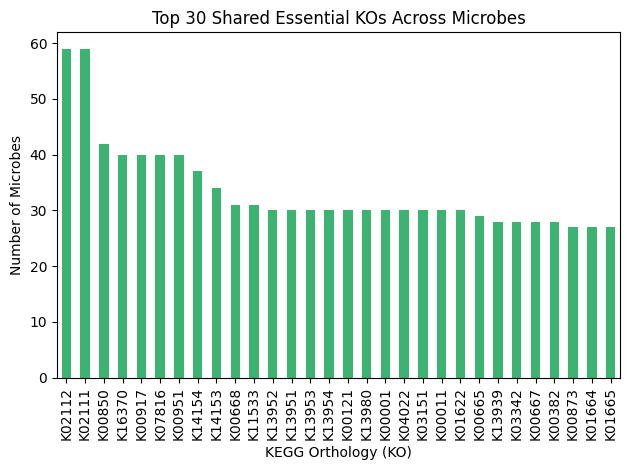

In [353]:
ko_microbe_counts = df.dropna(subset=['kegg_orthology']).groupby('kegg_orthology')['model'].nunique()
shared_kos = ko_microbe_counts[ko_microbe_counts > 1].sort_values(ascending=False).head(30)

shared_kos.plot(kind='bar', color='mediumseagreen')
plt.title("Top 30 Shared Essential KOs Across Microbes")
plt.xlabel("KEGG Orthology (KO)")
plt.ylabel("Number of Microbes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


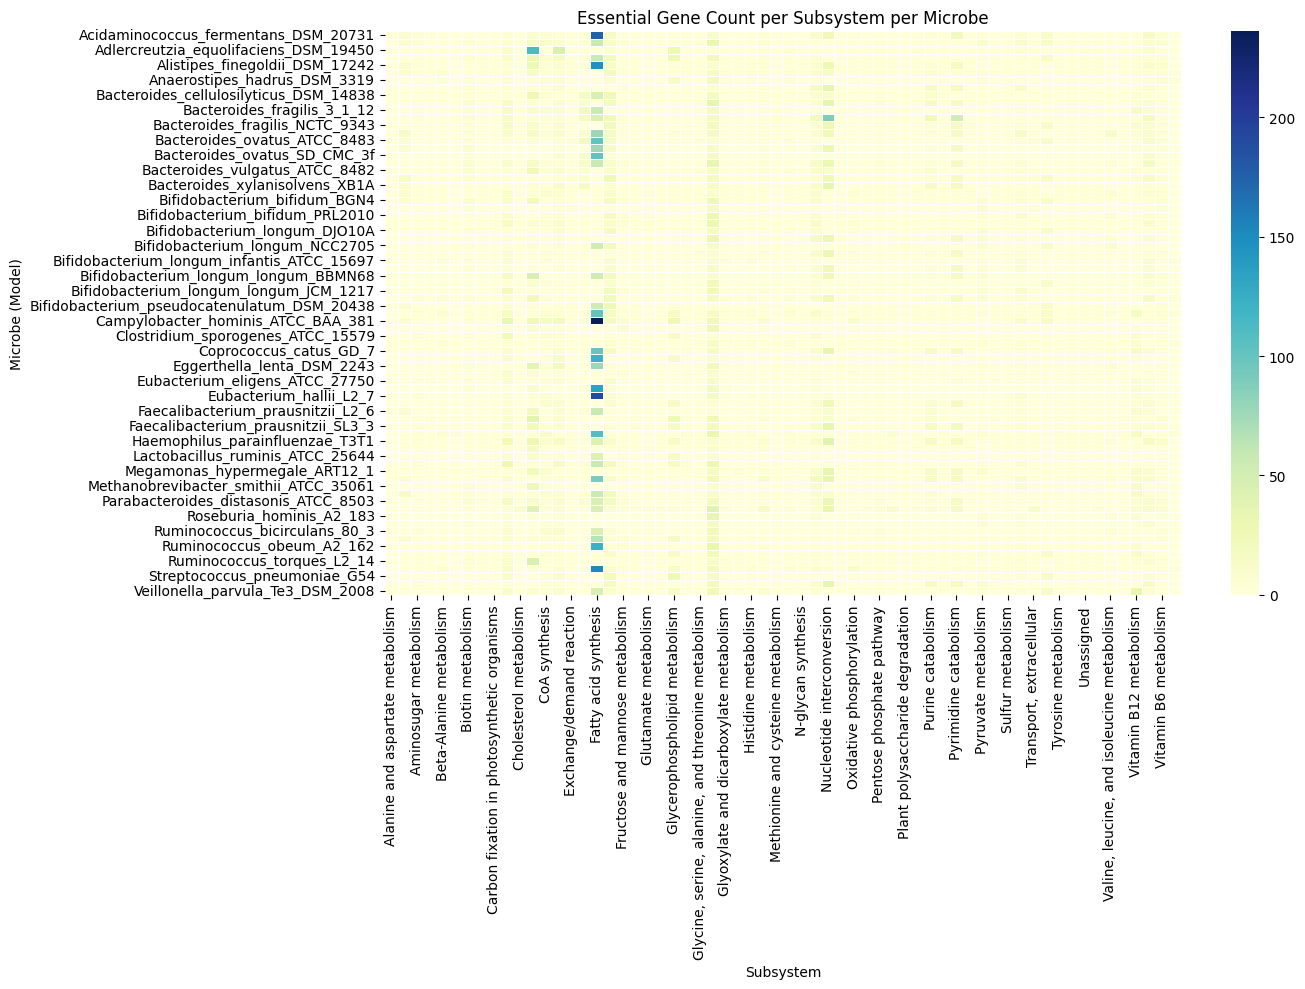

In [304]:
pivot = df.pivot_table(index='model', columns='subsystem', values='gene_id', aggfunc='count', fill_value=0)
plt.figure(figsize=(14, 10))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.7)
plt.title("Essential Gene Count per Subsystem per Microbe")
plt.xlabel("Subsystem")
plt.ylabel("Microbe (Model)")
plt.tight_layout()
plt.show()


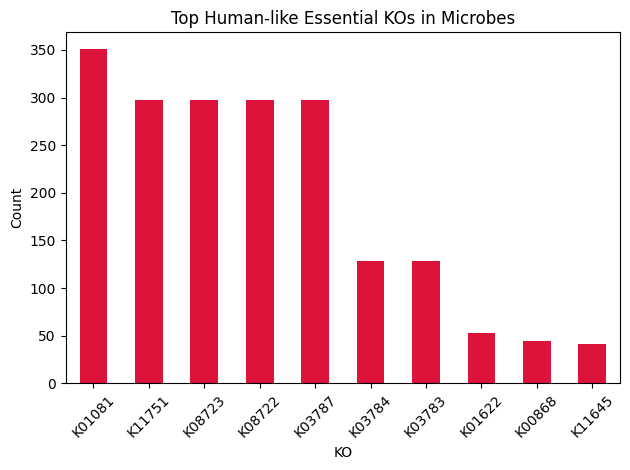

In [306]:
human_like = df[df['isHuman']]
human_ko_counts = human_like['kegg_orthology'].value_counts().head(10)

human_ko_counts.plot(kind='bar', color='crimson')
plt.title("Top Human-like Essential KOs in Microbes")
plt.xlabel("KO")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


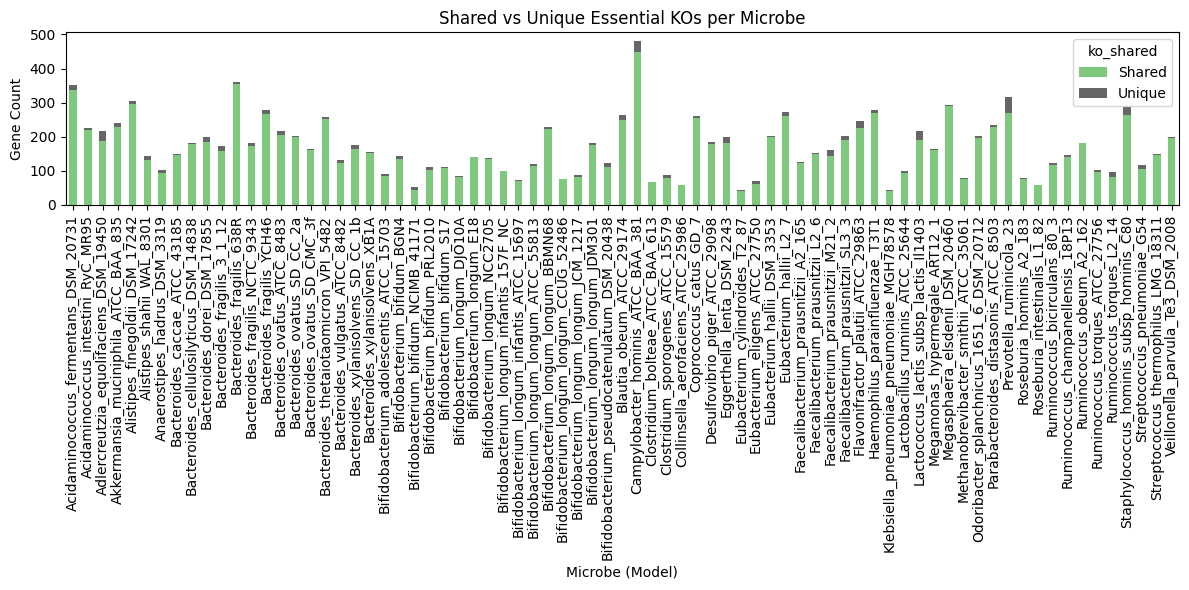

In [307]:
# Count KO frequency
ko_counts = df['kegg_orthology'].value_counts()

# Annotate each gene as shared or unique
df['ko_shared'] = df['kegg_orthology'].map(lambda x: 'Shared' if ko_counts.get(x, 0) > 1 else 'Unique')

# Count per model
shared_vs_unique = df.groupby(['model', 'ko_shared'])['gene_id'].count().unstack(fill_value=0)
shared_vs_unique.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Accent')
plt.title("Shared vs Unique Essential KOs per Microbe")
plt.xlabel("Microbe (Model)")
plt.ylabel("Gene Count")
plt.tight_layout()
plt.show()


/tmp/ipykernel_609256/1898947373.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_kos.values, y=top_kos.index, palette='viridis')


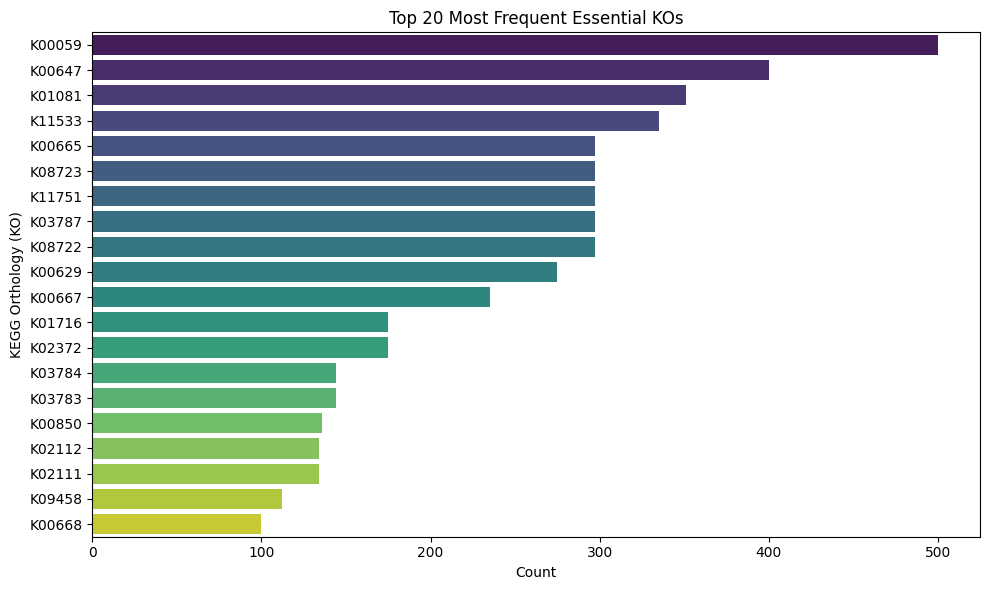

In [313]:
import seaborn as sns

top_kos = df['kegg_orthology'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_kos.values, y=top_kos.index, palette='viridis')
plt.xlabel("Count")
plt.ylabel("KEGG Orthology (KO)")
plt.title("Top 20 Most Frequent Essential KOs")
plt.tight_layout()
plt.show()


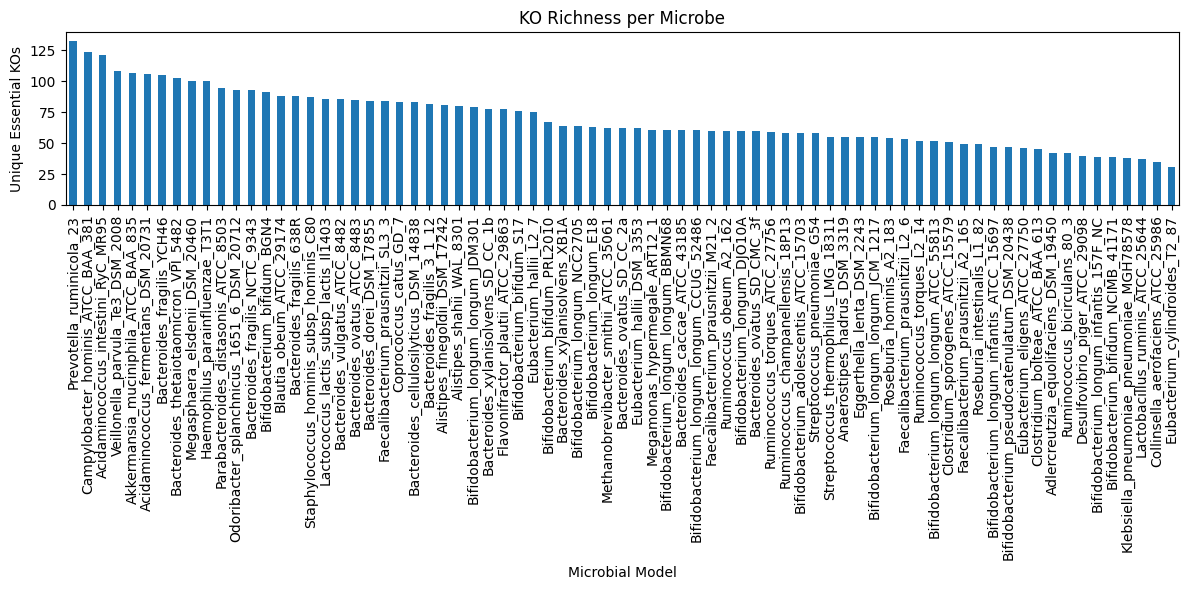

In [314]:
ko_per_microbe = df.groupby('model')['kegg_orthology'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ko_per_microbe.plot(kind='bar')
plt.ylabel("Unique Essential KOs")
plt.xlabel("Microbial Model")
plt.title("KO Richness per Microbe")
plt.tight_layout()
plt.show()


/new/benpyenv/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


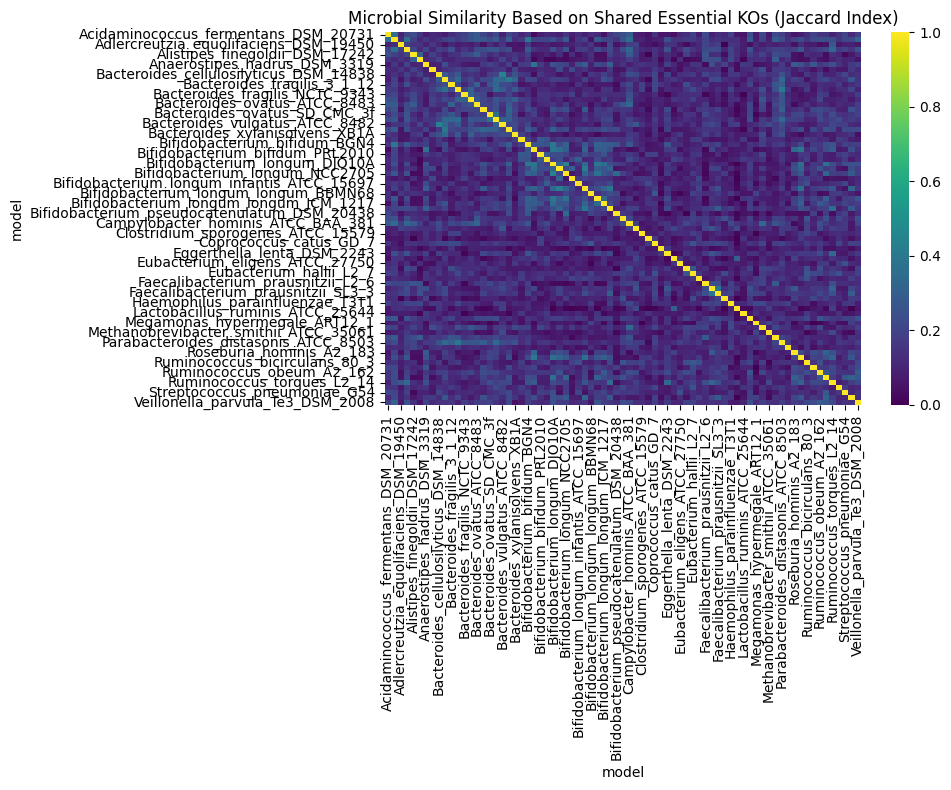

In [317]:
df = df.dropna(subset=['kegg_orthology'])

top_kos = df['kegg_orthology'].value_counts().nlargest(20)



# 2. Microbe-wise KO Richness
ko_per_microbe = df.groupby('model')['kegg_orthology'].nunique().sort_values(ascending=False)



# 3. KO Sharing Across Microbes (Jaccard Heatmap)
ko_matrix = df.groupby('model')['kegg_orthology'].apply(set)
mlb = MultiLabelBinarizer()
ko_binary = mlb.fit_transform(ko_matrix)
similarity = 1 - pairwise_distances(ko_binary, metric='jaccard')

# Convert to DataFrame for better axis labeling
similarity_df = pd.DataFrame(similarity, index=ko_matrix.index, columns=ko_matrix.index)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap="viridis")
plt.title("Microbial Similarity Based on Shared Essential KOs (Jaccard Index)")
plt.tight_layout()
plt.show()

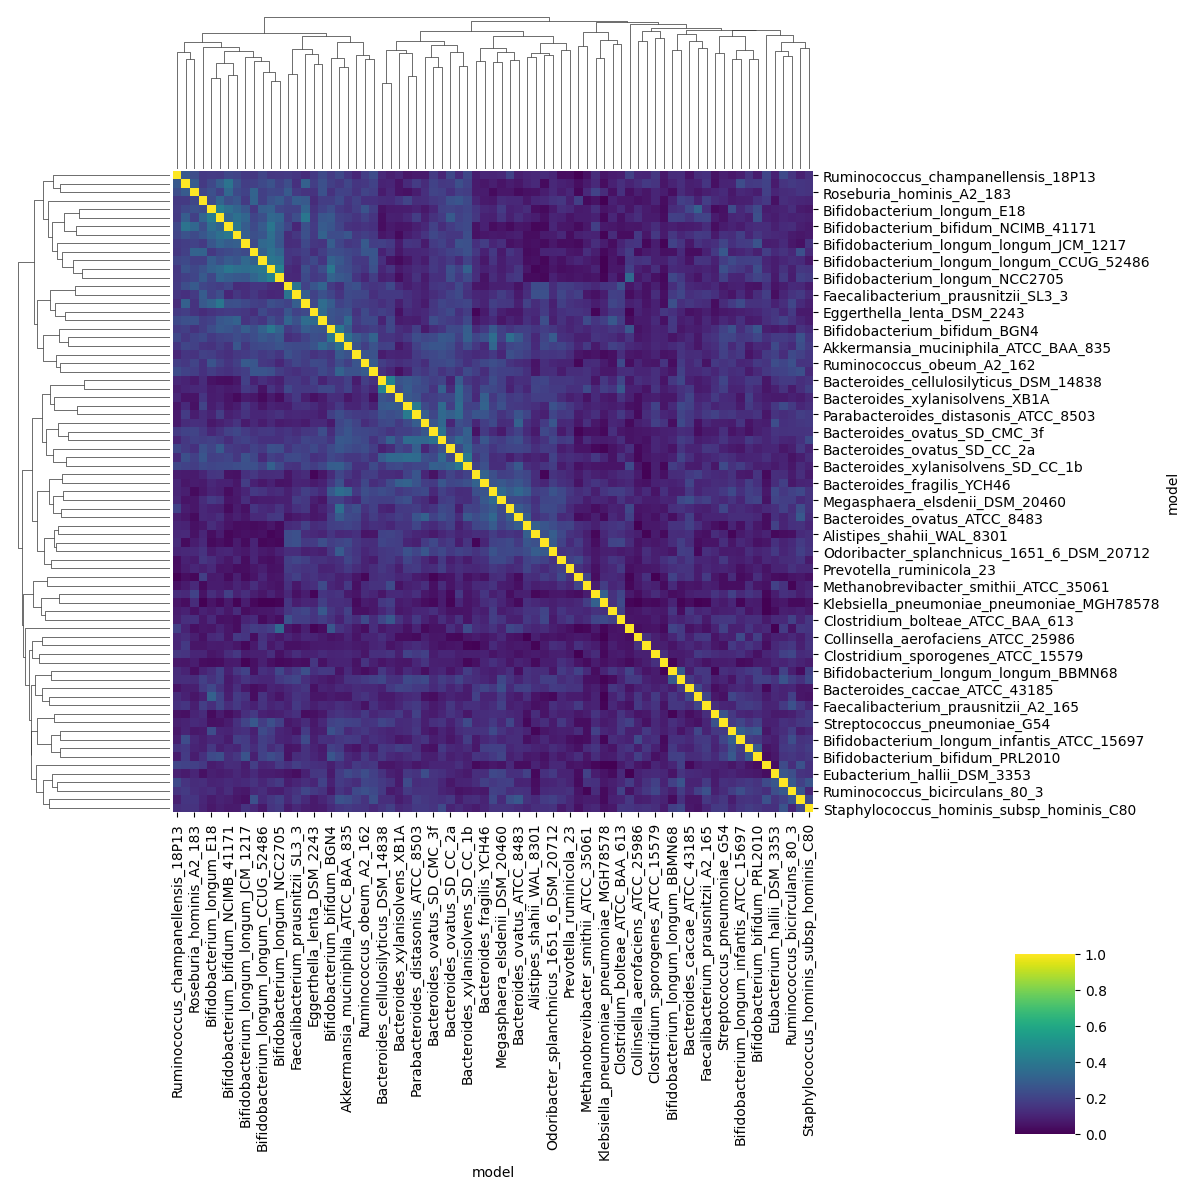

In [366]:
import scipy.cluster.hierarchy as sch

# Compute linkage for clustering
linkage = sch.linkage(similarity, method='average')

# Plot heatmap with clustering
sns.clustermap(similarity_df, row_linkage=linkage, col_linkage=linkage,
               cmap="viridis", figsize=(12, 12), cbar_pos=(0.85, 0.05, 0.05, 0.15))
# plt.title("Hierarchical Clustering of Microbes Based on Essential KO Similarity")
# plt.tight_layout()
# 
plt.show()


In [319]:
gene_df = pd.read_csv("gene_df_info.csv")

In [321]:
#Understand which functions are prevalent in each microbe.
ko_counts = gene_df.groupby(['model', 'kegg_orthology']).size().unstack(fill_value=0)
ko_counts.head()


kegg_orthology                         K00001  K00011  K00016  K00020  K00022  \
model                                                                           
Acidaminococcus_fermentans_DSM_20731        0       0       1       0       0   
Acidaminococcus_intestini_RyC_MR95          1       1       2       0       0   
Adlercreutzia_equolifaciens_DSM_19450       0       0       0       0       0   
Akkermansia_muciniphila_ATCC_BAA_835        1       1       0       0       0   
Alistipes_finegoldii_DSM_17242              0       0       0       0       0   

kegg_orthology                         K00024  K00025  K00026  K00030  K00031  \
model                                                                           
Acidaminococcus_fermentans_DSM_20731        0       0       0       0       0   
Acidaminococcus_intestini_RyC_MR95          0       0       0       0       0   
Adlercreutzia_equolifaciens_DSM_19450       0       0       0       0       0   
Akkermansia_muciniphila_ATCC_BAA_835        0       0       0       0       0   
Alistipes_finegoldii_DSM_17242              0       0       0       0       0   

kegg_orthology                         ...  K16305  K16306  K16329  K16330  \
model                                  ...                                   
Acidaminococcus_fermentans_DSM_20731   ...       0       0       0       0   
Acidaminococcus_intestini_RyC_MR95     ...       1       1       0       0   
Adlercreutzia_equolifaciens_DSM_19450  ...       0       0       0       0   
Akkermansia_muciniphila_ATCC_BAA_835   ...       0       0       0       0   
Alistipes_finegoldii_DSM_17242         ...       0       0       0       0   

kegg_orthology                         K16363  K16370  K16881  K17497  K17753  \
model                                                                           
Acidaminococcus_fermentans_DSM_20731        0       1       0       0       0   
Acidaminococcus_intestini_RyC_MR95          1       1       0       0       0   
Adlercreutzia_equolifaciens_DSM_19450       0       0       0       0       0   
Akkermansia_muciniphila_ATCC_BAA_835        0       1       0       0       0   
Alistipes_finegoldii_DSM_17242              0       0       0       0       0   

kegg_orthology                         K17865  
model                                          
Acidaminococcus_fermentans_DSM_20731        0  
Acidaminococcus_intestini_RyC_MR95          0  
Adlercreutzia_equolifaciens_DSM_19450       0  
Akkermansia_muciniphila_ATCC_BAA_835        0  
Alistipes_finegoldii_DSM_17242              0  

[5 rows x 483 columns]

In [322]:
#Find genes/functions shared across all microbes (core microbiome functions).
core_kos = gene_df.dropna(subset=['kegg_orthology']).groupby('model')['kegg_orthology'].apply(set)
shared_kos = set.intersection(*core_kos)
shared_kos


set()

In [323]:
#Identify functions enriched in human-associated microbes.
human_kos = gene_df[gene_df['isHuman'] == True]['kegg_orthology'].value_counts()
nonhuman_kos = gene_df[gene_df['isHuman'] == False]['kegg_orthology'].value_counts()

# Compare top differences
diff_kos = (human_kos - nonhuman_kos).dropna().sort_values(ascending=False)
diff_kos.head()



kegg_orthology
K03784    112.0
K03783    112.0
K01623     21.0
K14085     15.0
K00149     15.0
Name: count, dtype: float64

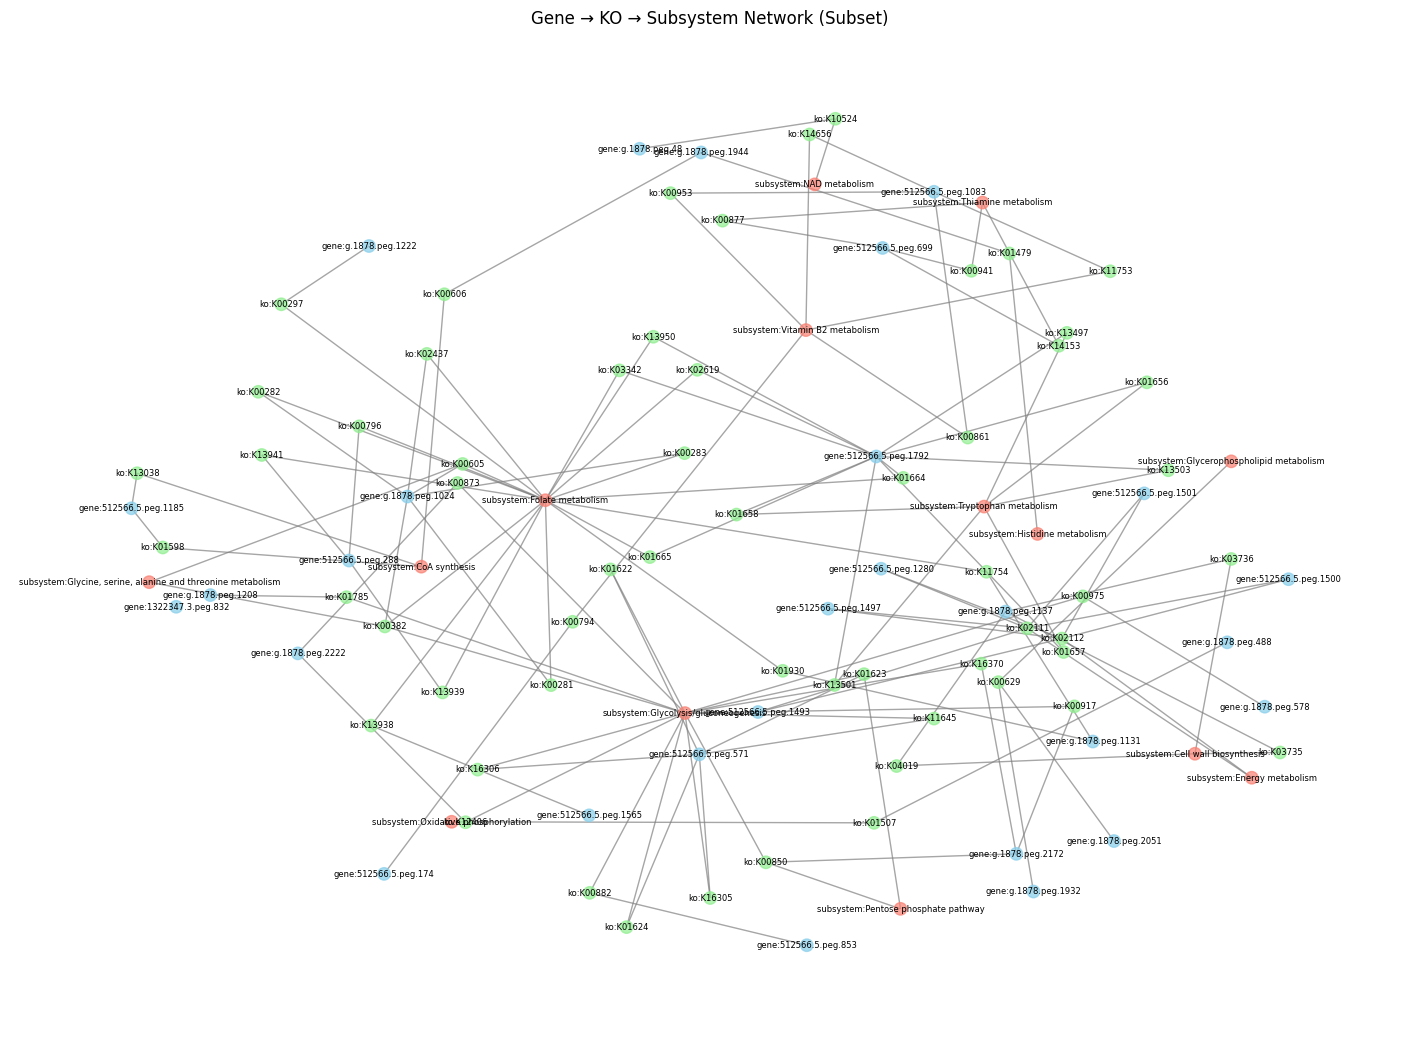

In [324]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter and drop NA values to make a cleaner graph
df_net = gene_df[['gene_id', 'kegg_orthology', 'subsystem']].dropna().drop_duplicates()

# Create graph
G = nx.Graph()

# Add nodes and edges
for _, row in df_net.iterrows():
    gene = f"gene:{row['gene_id']}"
    ko = f"ko:{row['kegg_orthology']}"
    subsystem = f"subsystem:{row['subsystem']}"

    G.add_node(gene, type='gene')
    G.add_node(ko, type='ko')
    G.add_node(subsystem, type='subsystem')

    G.add_edge(gene, ko)
    G.add_edge(ko, subsystem)

# Define node colors by type
color_map = {
    'gene': 'skyblue',
    'ko': 'lightgreen',
    'subsystem': 'salmon'
}
node_colors = [color_map[G.nodes[n]['type']] for n in G.nodes]

# Draw graph (small subset for clarity)
plt.figure(figsize=(14, 10))
subG = G.subgraph(list(G.nodes)[:100])  # limit to 100 nodes for visualization
pos = nx.spring_layout(subG, k=0.5)

nx.draw(subG, pos, with_labels=False, node_color=[color_map[G.nodes[n]['type']] for n in subG.nodes],
        node_size=80, edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(subG, pos, font_size=6)

plt.title("Gene → KO → Subsystem Network (Subset)")
plt.show()


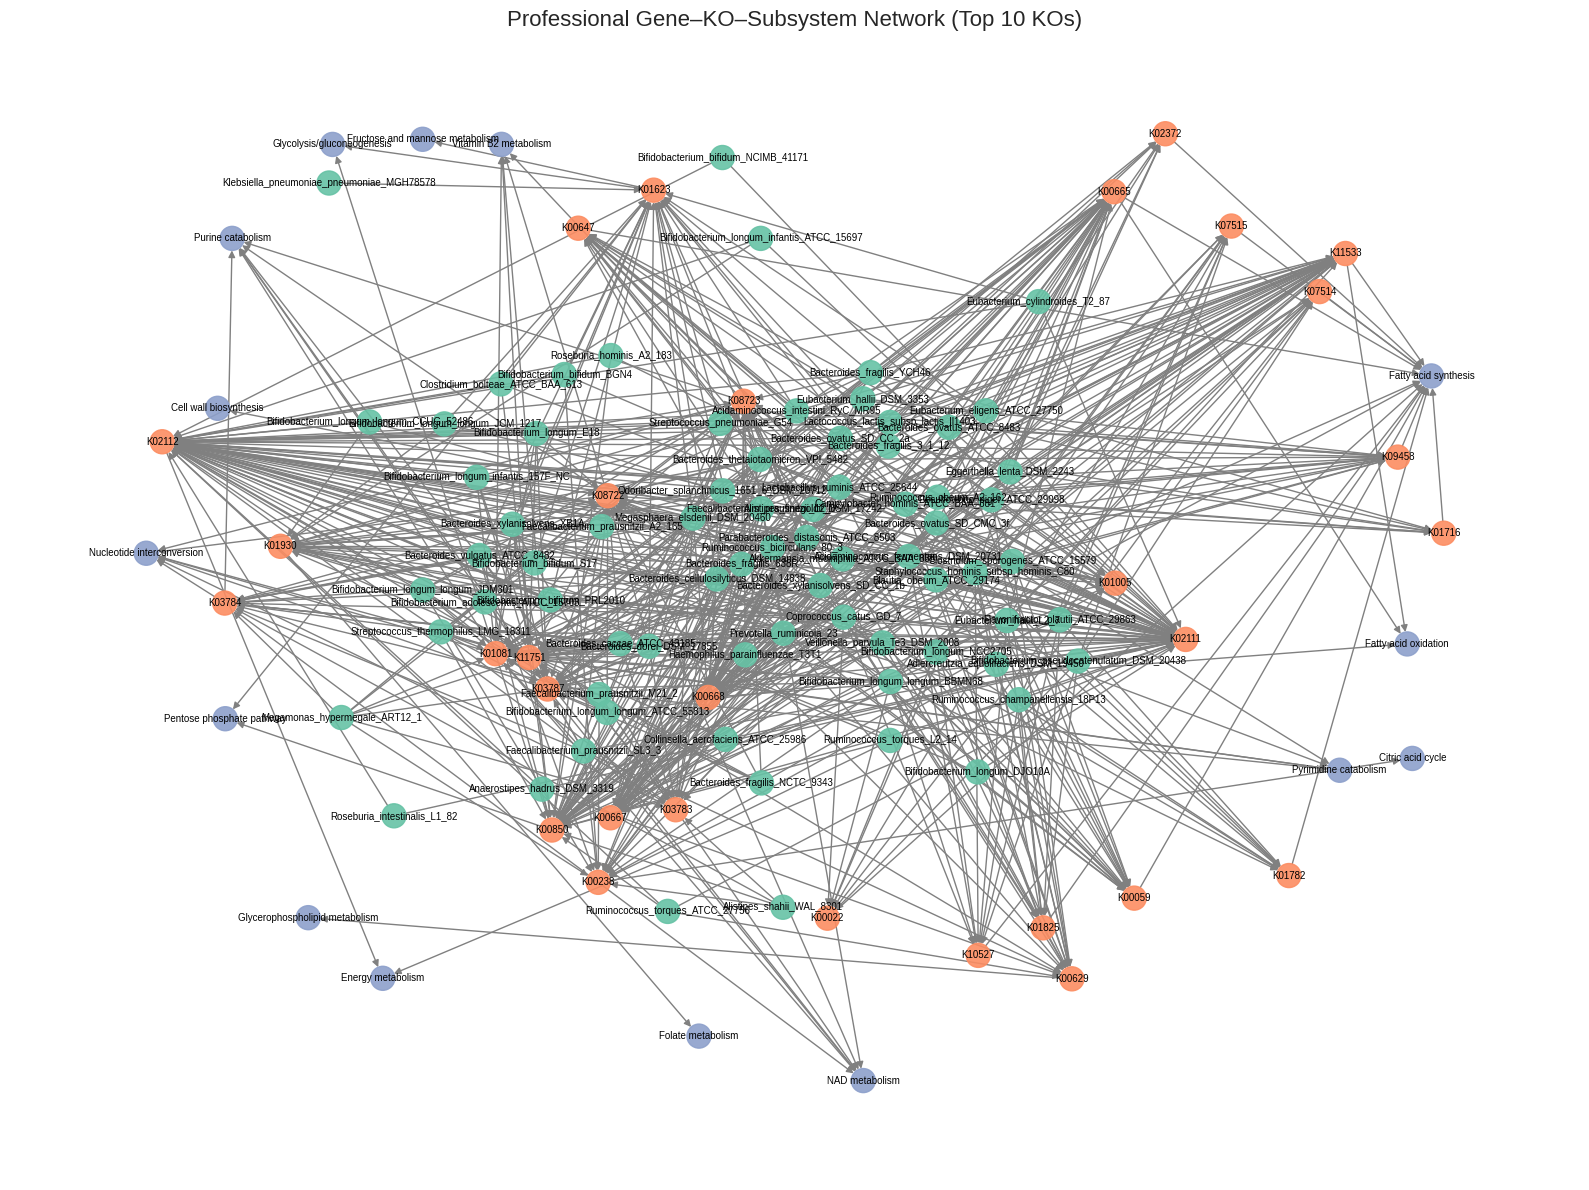

In [387]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter to a subset for visual clarity: top KOs and their gene-subsystem links
top_kos_subset = gene_df['kegg_orthology'].value_counts().head(30).index.tolist()
df_subset = gene_df[gene_df['kegg_orthology'].isin(top_kos_subset)]
df_subset = df_subset[['model', 'kegg_orthology', 'subsystem']].dropna().drop_duplicates()

# Create a directional graph
G = nx.DiGraph()

# Add edges: gene -> KO and KO -> subsystem
for _, row in df_subset.iterrows():
    gene_node = f"{row['model']}"
    ko_node = f"{row['kegg_orthology']}"
    subsystem_node = f"{row['subsystem']}"

    G.add_node(gene_node, type='strain')
    G.add_node(ko_node, type='ko')
    G.add_node(subsystem_node, type='subsystem')

    G.add_edge(gene_node, ko_node)
    G.add_edge(ko_node, subsystem_node)

# Define layout and colors
node_types = nx.get_node_attributes(G, 'type')
color_map = {'strain': '#66c2a5', 'ko': '#fc8d62', 'subsystem': '#8da0cb'}
node_colors = [color_map[node_types[n]] for n in G.nodes]

# Set figure size and draw
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=0.7, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Professional Gene–KO–Subsystem Network (Top 10 KOs)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


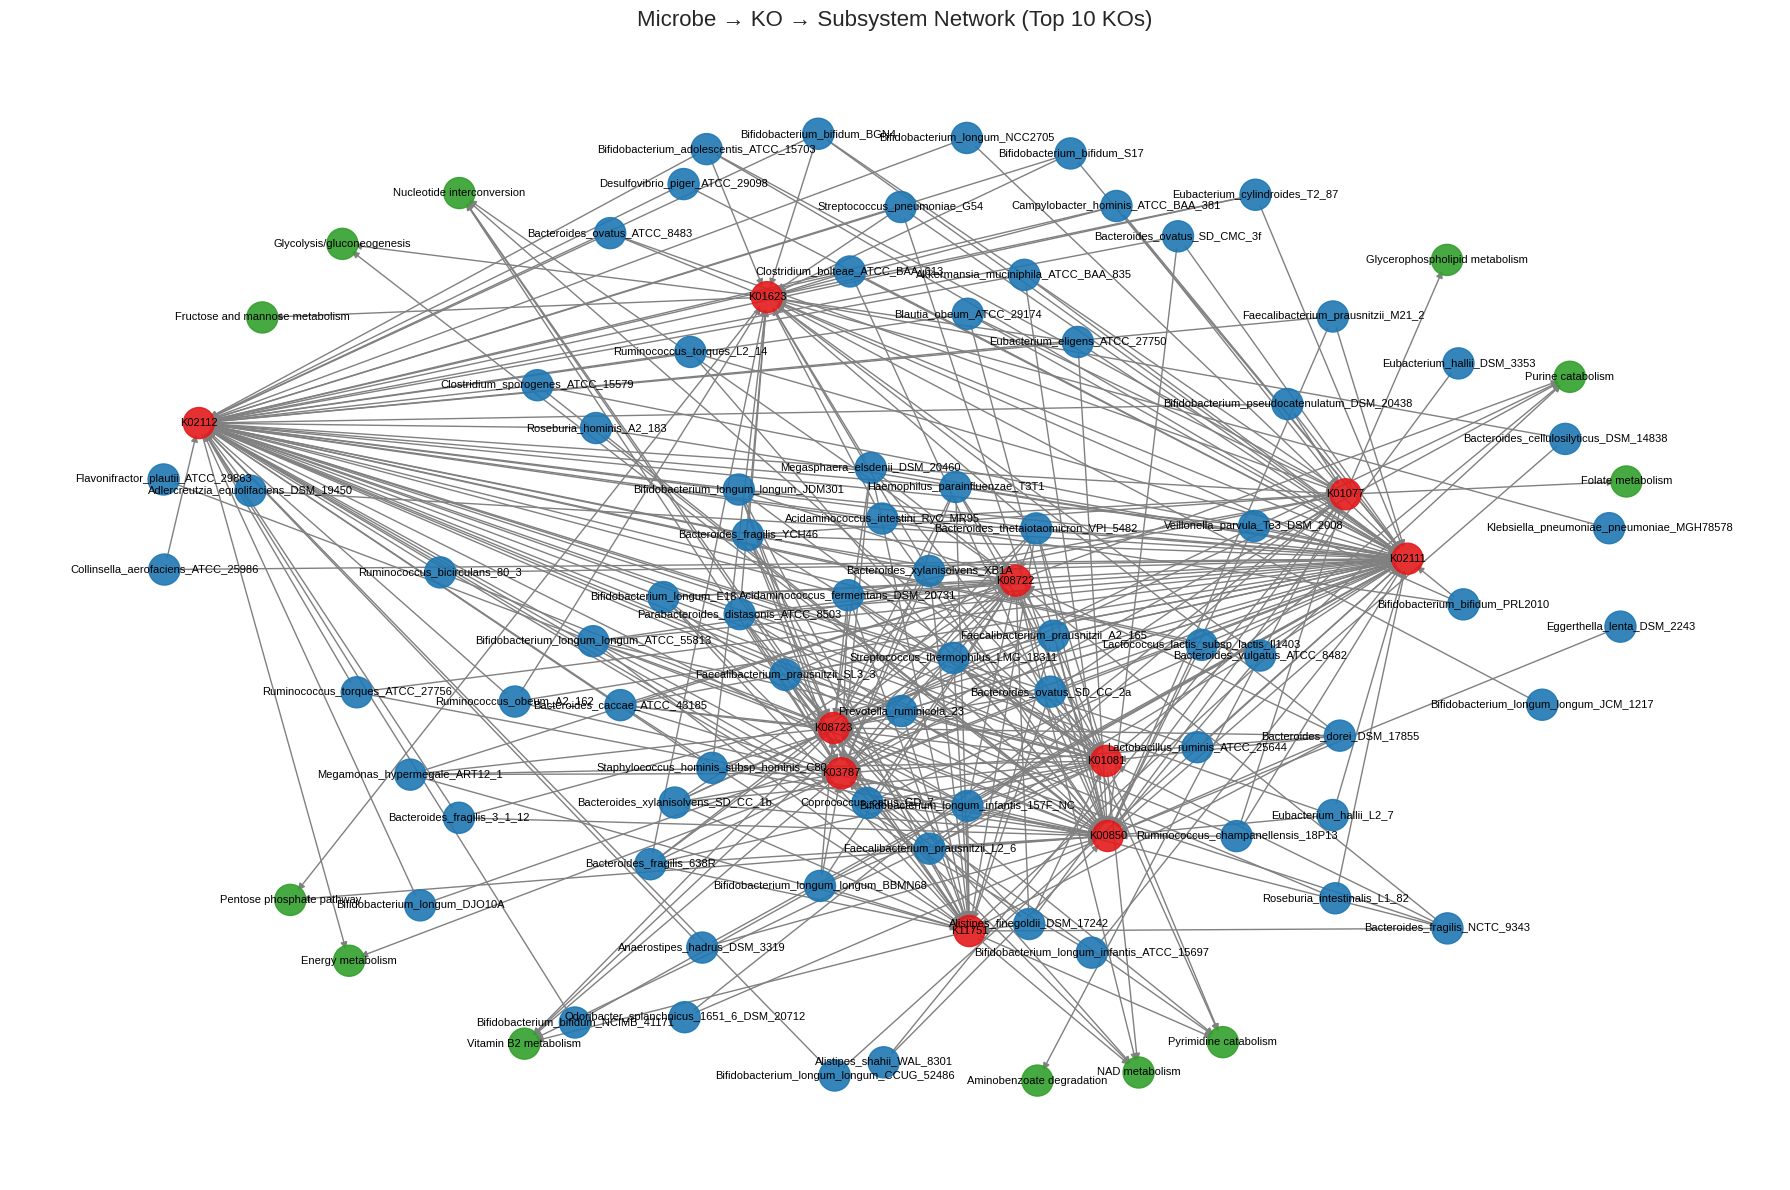

In [386]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your CSV file
df = pd.read_csv("gene_df_info.csv")

# Clean and filter relevant columns
df = df[['model', 'kegg_orthology', 'subsystem']].dropna().drop_duplicates()

# Limit to top 10 most frequent KOs for readability
top_kos = df['kegg_orthology'].value_counts().head(10).index.tolist()
df = df[df['kegg_orthology'].isin(top_kos)]

# Initialize directed graph
G = nx.DiGraph()

# Add edges: Microbe → KO → Subsystem
for _, row in df.iterrows():
    microbe = row['model']
    ko = row['kegg_orthology']
    subsystem = row['subsystem']

    G.add_node(microbe, type='microbe')
    G.add_node(ko, type='ko')
    G.add_node(subsystem, type='subsystem')

    G.add_edge(microbe, ko)
    G.add_edge(ko, subsystem)

# Assign node colors by type
node_types = nx.get_node_attributes(G, 'type')
color_map = {'microbe': '#1f78b4', 'ko': '#e31a1c', 'subsystem': '#33a02c'}
node_colors = [color_map[node_types[n]] for n in G.nodes]

# Set layout and plot
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=1.0, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.9)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Microbe → KO → Subsystem Network (Top 10 KOs)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


In [355]:
import pandas as pd
import networkx as nx

def perform_network_analysis(file_path="gene_df_info.csv"):
    """
    Performs network analysis on the provided gene information data.
    Specifically, it creates a microbe-KO (KEGG Orthology) network.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        networkx.Graph: The constructed microbe-KO network.
                        Returns None if an error occurs during data loading or processing.
    """
    try:
        # Attempt to load the dataframe
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory or provide the full path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV file '{file_path}': {e}")
        return None

    print("--- Data Loading and Preparation ---")
    # Define expected column names
    microbe_col = 'model'         # Column for microbe names
    ko_col = 'kegg_orthology' # Column for KO terms
    gene_col = 'gene_id'        # Column for gene identifiers

    # Check if all required columns are present
    required_cols = [microbe_col, ko_col, gene_col]
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: One or more required columns are missing from the CSV: {missing_cols}")
        print(f"Available columns: {df.columns.tolist()}")
        return None

    # Remove rows where the KO term is missing, as these cannot form a microbe-KO link
    df_filtered = df.dropna(subset=[ko_col])
    if df_filtered.empty:
        print(f"No data available after filtering out missing KO terms from column '{ko_col}'. Cannot build network.")
        return None

    print(f"Original number of rows in DataFrame: {len(df)}")
    print(f"Number of rows after removing entries with missing '{ko_col}': {len(df_filtered)}")

    print("\n--- Building Microbe-KO Network ---")
    # Group data by microbe and KO, then count the number of unique genes for each pair.
    # This count will serve as the weight of the edge between a microbe and a KO.
    microbe_ko_gene_counts = df_filtered.groupby([microbe_col, ko_col])[gene_col].nunique().reset_index()
    microbe_ko_gene_counts.rename(columns={gene_col: 'unique_gene_count'}, inplace=True)

    if microbe_ko_gene_counts.empty:
        print("No microbe-KO relationships found after grouping. Cannot build the network.")
        return None

    print(f"Found {len(microbe_ko_gene_counts)} unique microbe-KO relationships to form network edges.")

    # Initialize a new graph
    # This will be a bipartite-like graph where one set of nodes are microbes
    # and the other set are KO terms.
    G = nx.Graph()

    # Add nodes and edges to the graph
    # Microbe nodes will have a 'type' attribute set to 'microbe'
    # KO nodes will have a 'type' attribute set to 'ko'
    for _, row in microbe_ko_gene_counts.iterrows():
        microbe_node = str(row[microbe_col]) # Ensure node names are strings
        ko_node = str(row[ko_col])         # Ensure node names are strings
        weight = row['unique_gene_count']

        # Add microbe node if it doesn't already exist, with 'type' attribute
        if not G.has_node(microbe_node):
            G.add_node(microbe_node, type='microbe')
        # Add KO node if it doesn't already exist, with 'type' attribute
        if not G.has_node(ko_node):
            G.add_node(ko_node, type='ko')

        # Add an edge between the microbe and KO node, with weight representing unique gene count
        G.add_edge(microbe_node, ko_node, weight=weight)

    print("\n--- Basic Network Information ---")
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Number of nodes in the network: {num_nodes}")
    print(f"Number of edges in the network: {num_edges}")

    if num_nodes == 0:
        print("The constructed network is empty.")
        return G # Return the empty graph

    # Count and display the number of microbe and KO nodes
    microbe_nodes_set = {n for n, d in G.nodes(data=True) if d.get('type') == 'microbe'}
    ko_nodes_set = {n for n, d in G.nodes(data=True) if d.get('type') == 'ko'}
    print(f"Number of microbe type nodes: {len(microbe_nodes_set)}")
    print(f"Number of KO type nodes: {len(ko_nodes_set)}")


    print("\n--- Example Network Analysis: Degree and Weighted Degree (Strength) ---")
    
    # Unweighted degree (number of connections)
    print("\nTop 5 nodes by unweighted degree:")
    # Calculate degree for all nodes
    degrees = {node: val for node, val in G.degree()}
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
    for i, (node, deg) in enumerate(sorted_degrees[:5]):
        node_type = G.nodes[node].get('type', 'unknown')
        print(f"{i+1}. Node: {node} (Type: {node_type}), Degree: {deg}")

    # Weighted degree (strength: sum of edge weights)
    print("\nTop 5 microbe nodes by weighted degree (strength):")
    microbe_strength = {}
    if microbe_nodes_set: # Check if the set is not empty
        for m_node in microbe_nodes_set: # Iterate over the set of microbe nodes
            microbe_strength[m_node] = G.degree(m_node, weight='weight')
        sorted_microbe_strength = sorted(microbe_strength.items(), key=lambda item: item[1], reverse=True)
        for i, (node, strength) in enumerate(sorted_microbe_strength[:5]):
            print(f"{i+1}. Microbe: {node}, Strength (sum of unique genes): {strength}")
    else:
        print("No microbe nodes found to calculate strength.")


    print("\nTop 5 KO nodes by weighted degree (strength):")
    ko_strength = {}
    if ko_nodes_set: # Check if the set is not empty
        for k_node in ko_nodes_set: # Iterate over the set of KO nodes
            ko_strength[k_node] = G.degree(k_node, weight='weight')
        sorted_ko_strength = sorted(ko_strength.items(), key=lambda item: item[1], reverse=True)
        for i, (node, strength) in enumerate(sorted_ko_strength[:5]):
            print(f"{i+1}. KO: {node}, Strength (sum of unique genes): {strength}")
    else:
        print("No KO nodes found to calculate strength.")


    print("\n--- Further Network Analysis Suggestions ---")
    print("The following are suggestions for further analysis (code provided as examples to be run separately):")
    print("\n1. Bipartite Projections:")
    print("   - Microbe-Microbe Network (microbes linked if they share KOs):")
    print("     `microbe_nodes_list = [n for n, d in G.nodes(data=True) if d.get('type') == 'microbe']`")
    print("     `if microbe_nodes_list:`")
    print("     `  microbe_projection = nx.bipartite.projected_graph(G, microbe_nodes_list, weight=True)`") # Pass weight=True if you want weighted projections
    print("     `  # Then analyze microbe_projection, e.g., find central microbes in terms of shared functions.`")
    print("   - KO-KO Network (KOs linked if they co-occur in the same microbes):")
    print("     `ko_nodes_list = [n for n, d in G.nodes(data=True) if d.get('type') == 'ko']`")
    print("     `if ko_nodes_list:`")
    print("     `  ko_projection = nx.bipartite.projected_graph(G, ko_nodes_list, weight=True)`")
    print("     `  # Then analyze ko_projection, e.g., find clusters of functionally related KOs.`")
    print("\n2. Centrality Measures (on the main graph or projections):")
    print("   - Betweenness Centrality (identifies nodes that bridge different parts of the network):")
    print("     `betweenness_centrality = nx.betweenness_centrality(G, weight='weight')`")
    print("   - Eigenvector Centrality (identifies nodes connected to other important nodes):")
    print("     `eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000, tol=1.0e-3)`")
    print("\n3. Community Detection (on projections, or using bipartite-specific algorithms):")
    print("   - For example, on a microbe projection:")
    print("     `# Assuming microbe_projection is created as shown above`")
    print("     `# communities = nx.community.louvain_communities(microbe_projection, weight='weight')`")
    print("\n4. Path Analysis:")
    print("   - Find shortest paths between specific microbes and KOs or within projections.")
    print("     `# if G.has_node('Microbe_A') and G.has_node('KO_X'):`")
    print("     `#   path = nx.shortest_path(G, source='Microbe_A', target='KO_X', weight='weight')`")

    return G

# How to use the function:
if __name__ == '__main__':
    print("Initiating network analysis from gene data...")
    
    # Make sure 'gene_df_info.csv' is in the same directory as this script,
    # or provide the full path to the file.
    gene_file = "gene_df_info.csv" 
    
    # Call the function to perform network analysis
    network_graph_object = perform_network_analysis(file_path=gene_file)

    # After the function runs, 'network_graph_object' will hold the NetworkX graph.
    # You can then use this object for further analysis if you are running this interactively
    # or add more processing steps directly in this script.
    if network_graph_object and network_graph_object.number_of_nodes() > 0:
        print("\nNetwork analysis script completed successfully.")
        print("The NetworkX graph object is now created.")
        # Example: You could inspect some properties of the graph
        # print(f"Graph density: {nx.density(network_graph_object):.4f}")
    elif network_graph_object and network_graph_object.number_of_nodes() == 0:
        print("\nNetwork analysis script completed, but the resulting network is empty.")
    else:
        print("\nNetwork analysis script did not complete successfully or could not build a network.")

Initiating network analysis from gene data...
--- Data Loading and Preparation ---
Original number of rows in DataFrame: 12832
Number of rows after removing entries with missing 'kegg_orthology': 12257

--- Building Microbe-KO Network ---
Found 5231 unique microbe-KO relationships to form network edges.

--- Basic Network Information ---
Number of nodes in the network: 558
Number of edges in the network: 5231
Number of microbe type nodes: 75
Number of KO type nodes: 483

--- Example Network Analysis: Degree and Weighted Degree (Strength) ---

Top 5 nodes by unweighted degree:
1. Node: Prevotella_ruminicola_23 (Type: microbe), Degree: 133
2. Node: Campylobacter_hominis_ATCC_BAA_381 (Type: microbe), Degree: 124
3. Node: Acidaminococcus_intestini_RyC_MR95 (Type: microbe), Degree: 121
4. Node: Veillonella_parvula_Te3_DSM_2008 (Type: microbe), Degree: 108
5. Node: Akkermansia_muciniphila_ATCC_BAA_835 (Type: microbe), Degree: 107

Top 5 microbe nodes by weighted degree (strength):
1. Microbe

Initiating network analysis with visualization...
--- Data Loading and Preparation ---
Original rows: 12832, Rows after filtering NA KOs: 12257

--- Building Microbe-KO Network ---
Found 5231 unique microbe-KO relationships.

--- Basic Network Information ---
Nodes: 558, Edges: 5231
Microbe nodes: 75, KO nodes: 483

--- Example Network Analysis: Degree & Strength ---

Top 5 nodes by unweighted degree:
1. Prevotella_ruminicola_23 (Type: microbe), Degree: 133
2. Campylobacter_hominis_ATCC_BAA_381 (Type: microbe), Degree: 124
3. Acidaminococcus_intestini_RyC_MR95 (Type: microbe), Degree: 121
4. Veillonella_parvula_Te3_DSM_2008 (Type: microbe), Degree: 108
5. Akkermansia_muciniphila_ATCC_BAA_835 (Type: microbe), Degree: 107

Top 5 microbe nodes by weighted degree (strength):
1. Campylobacter_hominis_ATCC_BAA_381, Strength: 177
2. Prevotella_ruminicola_23, Strength: 172
3. Acidaminococcus_intestini_RyC_MR95, Strength: 137
4. Haemophilus_parainfluenzae_T3T1, Strength: 125
5. Akkermansia_muci

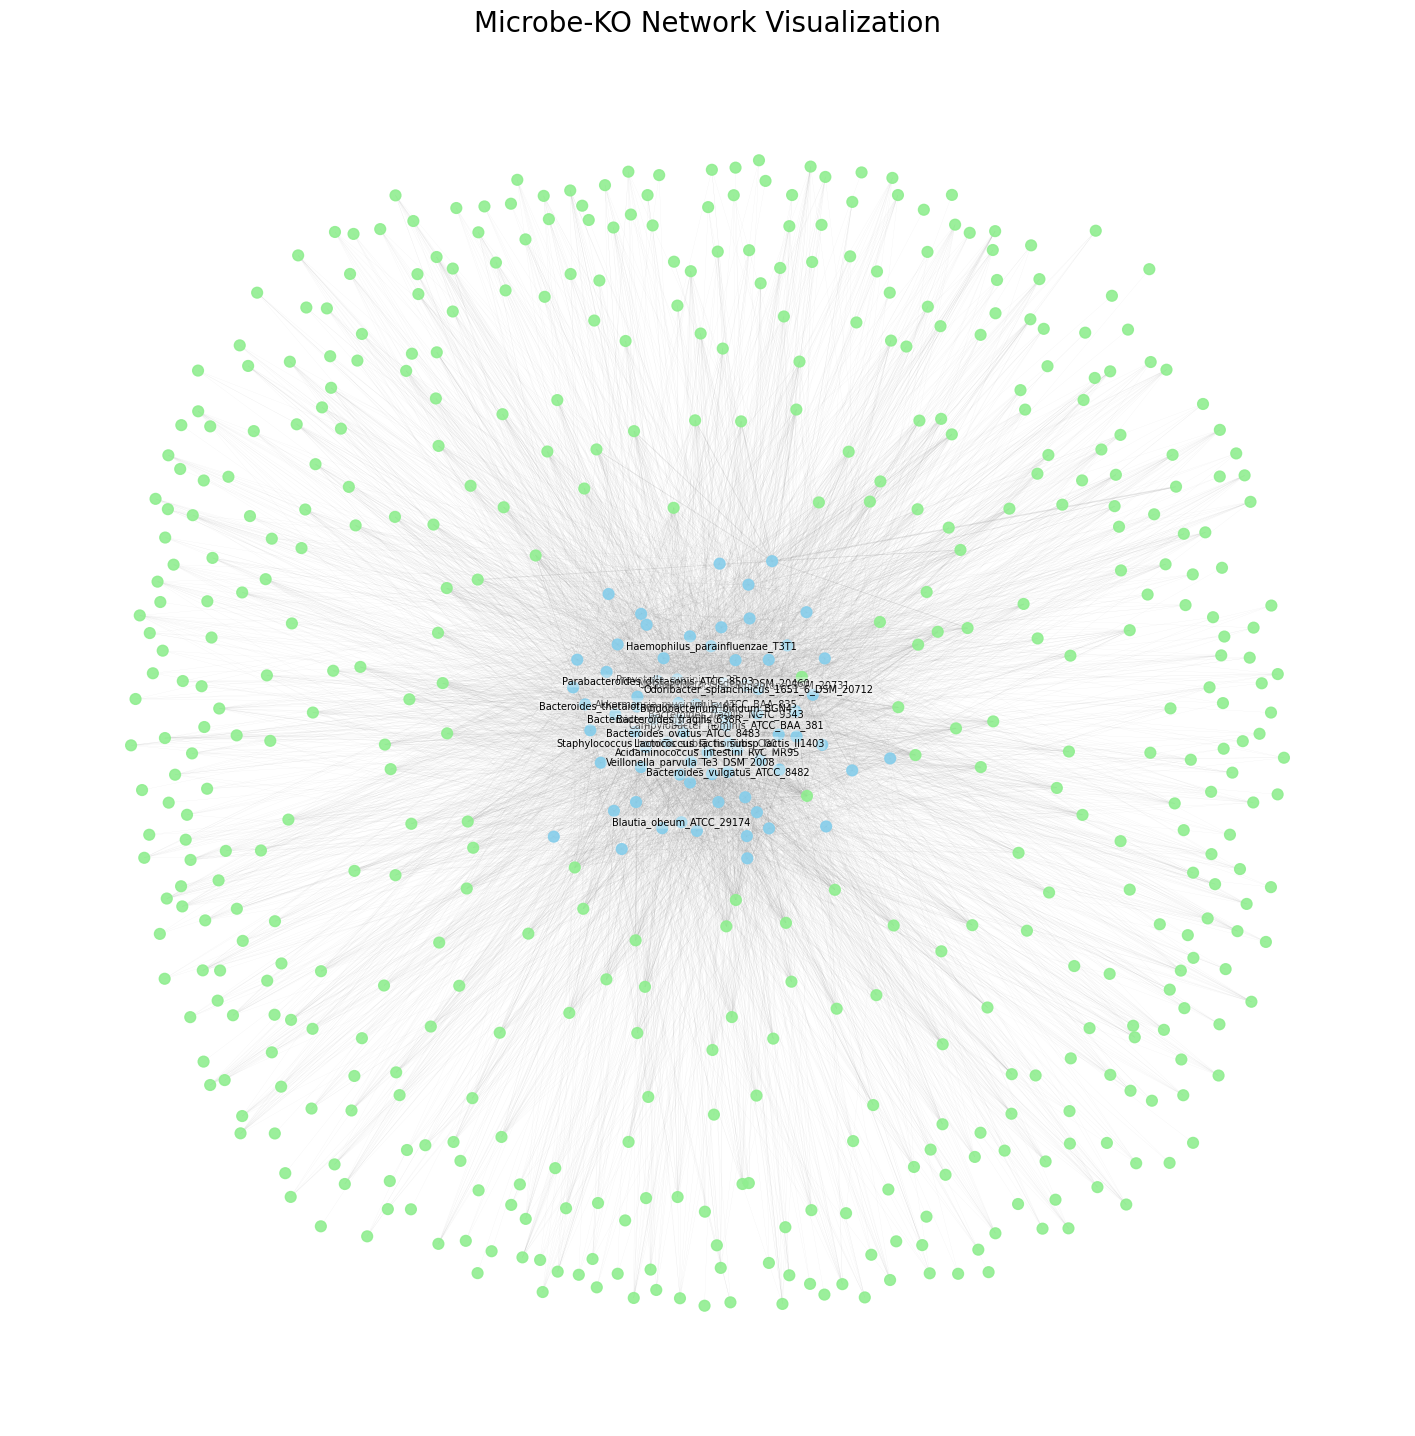


--- Further Network Analysis Suggestions ---
For detailed analysis, consider bipartite projections, other centrality measures (betweenness, eigenvector), or community detection algorithms.

Network analysis and visualization script completed.


In [368]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def perform_network_analysis_with_figure(file_path="gene_df_info.csv"):
    """
    Performs network analysis on the provided gene information data,
    creates a microbe-KO (KEGG Orthology) network, and visualizes it.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        networkx.Graph: The constructed microbe-KO network.
                        Returns None if an error occurs.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV file '{file_path}': {e}")
        return None

    print("--- Data Loading and Preparation ---")
    microbe_col = 'model'
    ko_col = 'kegg_orthology'
    gene_col = 'gene_id'

    required_cols = [microbe_col, ko_col, gene_col]
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        print(f"Error: One or more required columns are missing: {missing_cols}")
        return None

    df_filtered = df.dropna(subset=[ko_col])
    if df_filtered.empty:
        print(f"No data after filtering missing '{ko_col}'. Cannot build network.")
        return None

    print(f"Original rows: {len(df)}, Rows after filtering NA KOs: {len(df_filtered)}")

    print("\n--- Building Microbe-KO Network ---")
    microbe_ko_gene_counts = df_filtered.groupby([microbe_col, ko_col])[gene_col].nunique().reset_index()
    microbe_ko_gene_counts.rename(columns={gene_col: 'unique_gene_count'}, inplace=True)

    if microbe_ko_gene_counts.empty:
        print("No microbe-KO relationships found. Cannot build network.")
        return None

    print(f"Found {len(microbe_ko_gene_counts)} unique microbe-KO relationships.")

    G = nx.Graph()
    microbe_nodes_list = [] # To store microbe node names
    ko_nodes_list = []      # To store KO node names

    for _, row in microbe_ko_gene_counts.iterrows():
        microbe_node = str(row[microbe_col])
        ko_node = str(row[ko_col])
        weight = row['unique_gene_count']

        if not G.has_node(microbe_node):
            G.add_node(microbe_node, type='microbe')
            microbe_nodes_list.append(microbe_node)
        if not G.has_node(ko_node):
            G.add_node(ko_node, type='ko')
            ko_nodes_list.append(ko_node)
        G.add_edge(microbe_node, ko_node, weight=weight)

    print("\n--- Basic Network Information ---")
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"Nodes: {num_nodes}, Edges: {num_edges}")
    print(f"Microbe nodes: {len(microbe_nodes_list)}, KO nodes: {len(ko_nodes_list)}")

    if num_nodes == 0:
        print("Network is empty.")
        return G

    # Assign colors for visualization based on node type
    color_map = []
    for node in G:
        if G.nodes[node]['type'] == 'microbe':
            color_map.append('skyblue')
        elif G.nodes[node]['type'] == 'ko':
            color_map.append('lightgreen')
        else:
            color_map.append('grey') # Fallback color

    print("\n--- Example Network Analysis: Degree & Strength ---")
    degrees = {node: val for node, val in G.degree()}
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
    print("\nTop 5 nodes by unweighted degree:")
    for i, (node, deg) in enumerate(sorted_degrees[:5]):
        print(f"{i+1}. {node} (Type: {G.nodes[node].get('type')}), Degree: {deg}")

    # Calculate strength for microbe nodes
    microbe_strength = {n: G.degree(n, weight='weight') for n in microbe_nodes_list if G.has_node(n)}
    sorted_microbe_strength = sorted(microbe_strength.items(), key=lambda item: item[1], reverse=True)
    print("\nTop 5 microbe nodes by weighted degree (strength):")
    for i, (node, strength) in enumerate(sorted_microbe_strength[:5]):
        print(f"{i+1}. {node}, Strength: {strength}")
    
    # Calculate strength for KO nodes
    ko_strength = {n: G.degree(n, weight='weight') for n in ko_nodes_list if G.has_node(n)}
    sorted_ko_strength = sorted(ko_strength.items(), key=lambda item: item[1], reverse=True)
    print("\nTop 5 KO nodes by weighted degree (strength):")
    for i, (node, strength) in enumerate(sorted_ko_strength[:5]):
        print(f"{i+1}. {node}, Strength: {strength}")


    print("\n--- Network Visualization ---")
    if num_nodes > 0:
        plt.figure(figsize=(18, 18)) 
        
        if num_nodes > 200: 
            print("Graph is large, using spring_layout with fewer iterations for visualization performance.")
            pos = nx.spring_layout(G, k=0.5, iterations=20) 
        else:
            pos = nx.kamada_kawai_layout(G) # Good for smaller, complex graphs

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=60, alpha=0.9) # Slightly larger nodes
        
        # Draw edges
        # Scale edge widths, ensure minimum width for visibility
        edge_widths = [max(0.1, G[u][v]['weight'] / 10.0) for u,v in G.edges()] 
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.2, edge_color='grey')
        
        # Draw labels
        labels_to_draw = {}
        if num_nodes < 100: 
            labels_to_draw = {node: node for node in G.nodes()}
        else: 
            print("Labeling only top 20 degree nodes due to graph size.")
            top_nodes_by_degree = [node for node, deg in sorted_degrees[:20]]
            for node in top_nodes_by_degree:
                 labels_to_draw[node] = node
        
        nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=7, font_color='black', 
                                bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', boxstyle='round,pad=0.1'))


        plt.title("Microbe-KO Network Visualization", fontsize=20)
        plt.axis('off') 
        
        fig_filename = "microbe_ko_network.png"
        try:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=150) # Added bbox_inches and dpi
            print(f"Network visualization saved as '{fig_filename}'")
        except Exception as e:
            print(f"Error saving figure: {e}")
        plt.show()

    else:
        print("Skipping visualization as the network is empty.")
        
    print("\n--- Further Network Analysis Suggestions ---")
    print("For detailed analysis, consider bipartite projections, other centrality measures (betweenness, eigenvector), or community detection algorithms.")

    return G

if __name__ == '__main__':
    print("Initiating network analysis with visualization...")
    gene_file = "gene_df_info.csv" # Make sure this file is in the same directory or provide the full path
    
    network_graph = perform_network_analysis_with_figure(file_path=gene_file)

    if network_graph and network_graph.number_of_nodes() > 0:
        print("\nNetwork analysis and visualization script completed.")
    elif network_graph and network_graph.number_of_nodes() == 0:
        print("\nNetwork analysis script completed, but the resulting network is empty.")
    else:
        print("\nNetwork analysis script did not complete successfully.")